<a href="https://colab.research.google.com/github/Azaidi317/Segmentation-SAM/blob/main/diffusion_based_trajectory_generation_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U jupyter_http_over_ws
!jupyter serverextension enable --sys-prefix jupyter_http_over_ws

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.5 MB/s eta 0:00:00
Enabling: jupyter_http_over_ws
- Writing config: /usr/etc/jupyter
    - Validating...
      jupyter_http_over_ws 0.0.7 OK


In [ ]:
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
import numpy as np

# Initialize NuScenes
dataroot = "/users/azaidi/Downloads/v1.0-mini 2"  # Adjust if needed
nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)

def analyze_sample(nusc, sample_token):
    sample = nusc.get('sample', sample_token)
    helper = PredictHelper(nusc)

    print(f"\nAnalyzing sample: {sample_token}")
    print(f"Number of annotations: {len(sample['anns'])}")

    # Analyze each annotation
    for idx, ann_token in enumerate(sample['anns']):
        ann = nusc.get('sample_annotation', ann_token)

        print(f"\nAnnotation {idx + 1}:")
        print(f"Category: {ann['category_name']}")
        print(f"Position: {[round(x, 2) for x in ann['translation']]}")

        # Get trajectory data
        instance_token = ann['instance_token']
        try:
            future = helper.get_future_for_agent(
                instance_token,
                sample_token,
                seconds=6.0,
                in_agent_frame=True  # Added missing parameter
            )
            past = helper.get_past_for_agent(
                instance_token,
                sample_token,
                seconds=2.0,
                in_agent_frame=True  # Added missing parameter
            )

            print(f"Past trajectory points: {len(past)}")
            print(f"Future trajectory points: {len(future)}")

            if len(past) > 0:
                print("Past positions (last 2):")
                print(past[-2:] if len(past) >= 2 else past)

            if len(future) > 0:
                print("Future positions (first 2):")
                print(future[:2] if len(future) >= 2 else future)

        except Exception as e:
            print(f"Error getting trajectory: {e}")

        # Break after first 3 annotations to keep output manageable
        if idx == 2:
            print("\n... (showing first 3 annotations only)")
            break

# Get the first scene's first sample
first_scene = nusc.scene[0]
first_sample_token = first_scene['first_sample_token']

# Analyze sample
analyze_sample(nusc, first_sample_token)

# Print scene statistics
print("\nScene Statistics:")
print(f"Scene description: {first_scene['description']}")
print(f"Log token: {first_scene['log_token']}")
print(f"Number of samples: {len(nusc.sample)}")

# Count annotation categories
categories = {}
for ann_token in nusc.sample[0]['anns']:
    ann = nusc.get('sample_annotation', ann_token)
    cat = ann['category_name']
    categories[cat] = categories.get(cat, 0) + 1

print("\nAnnotation categories in first sample:")
for cat, count in sorted(categories.items()):
    print(f"- {cat}: {count}")

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.058 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.

Analyzing sample: ca9a282c9e77460f8360f564131a8af5
Number of annotations: 69

Annotation 1:
Category: human.pedestrian.adult
Position: [373.26, 1130.42, 0.8]
Past trajectory points: 0
Future trajectory points: 12
Future positions (first 2):
[[0. 0.]
 [0. 0.]]

Annotation 2:
Category: human.pedestrian.adult
Position: [378.89, 1153.35, 0.86]
Past trajectory points: 0
Future trajectory points: 12
Future positions (first 2):
[[-0.01285847  0.62956228]
 [-0.02610585  1.26004583]]

Annotation 3:
Category: vehicle.car
Position: [353.79, 1132.36, 0.6]
Past trajectory points: 0
Future trajectory points: 12
Future positions (first 2):
[[-2.92035109e-04 -1.96955507e-02]
 [-5.688

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from typing import Dict, List, Tuple

class TrajectoryDataset(Dataset):
    def __init__(self,
                 nusc: NuScenes,
                 helper: PredictHelper,
                 history_seconds: float = 2.0,
                 future_seconds: float = 6.0,
                 history_freq: float = 2,  # 2Hz
                 future_freq: float = 2):  # 2Hz
        self.nusc = nusc
        self.helper = helper
        self.history_seconds = history_seconds
        self.future_seconds = future_seconds

        # Calculate number of steps
        self.history_steps = int(history_seconds * history_freq)
        self.future_steps = int(future_seconds * future_freq)

        # Collect all valid sample tokens and instance tokens
        self.samples = []
        for scene in nusc.scene:
            sample_token = scene['first_sample_token']
            while sample_token:
                sample = nusc.get('sample', sample_token)
                for ann_token in sample['anns']:
                    ann = nusc.get('sample_annotation', ann_token)
                    # Only include vehicles and pedestrians
                    if ann['category_name'].startswith(('vehicle', 'human')):
                        self.samples.append({
                            'sample_token': sample_token,
                            'instance_token': ann['instance_token'],
                            'category': ann['category_name']
                        })
                sample_token = sample['next']

        print(f"Found {len(self.samples)} valid trajectories")

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        sample = self.samples[idx]

        # Get trajectories
        past = self.helper.get_past_for_agent(
            sample['instance_token'],
            sample['sample_token'],
            seconds=self.history_seconds,
            in_agent_frame=True
        )

        future = self.helper.get_future_for_agent(
            sample['instance_token'],
            sample['sample_token'],
            seconds=self.future_seconds,
            in_agent_frame=True
        )

        # Convert to tensors
        past_tensor = torch.zeros(self.history_steps, 2)
        if len(past) > 0:
            past_tensor[-len(past):] = torch.tensor(past)

        future_tensor = torch.zeros(self.future_steps, 2)
        if len(future) > 0:
            future_tensor[:len(future)] = torch.tensor(future)

        return {
            'past': past_tensor,
            'future': future_tensor,
            'category': sample['category']
        }

class DiffusionModel(nn.Module):
    def __init__(self,
                 history_steps: int,
                 future_steps: int,
                 hidden_size: int = 256,
                 num_diffusion_steps: int = 1000):
        super().__init__()
        self.history_steps = history_steps
        self.future_steps = future_steps
        self.num_diffusion_steps = num_diffusion_steps

        # Encoder for past trajectory
        self.history_encoder = nn.Sequential(
            nn.Linear(history_steps * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size + hidden_size + future_steps * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, future_steps * 2)
        )

        # Setup noise schedule
        betas = torch.linspace(1e-4, 0.02, num_diffusion_steps)
        alphas = 1 - betas
        self.register_buffer('alphas_cumprod', torch.cumprod(alphas, dim=0))

    def forward(self, history: torch.Tensor, noisy_future: torch.Tensor,
                timesteps: torch.Tensor) -> torch.Tensor:
        # Encode history
        history_feat = self.history_encoder(history.reshape(history.shape[0], -1))

        # Embed timesteps
        time_feat = self.time_embed(timesteps.unsqueeze(-1).float())

        # Combine features
        combined = torch.cat([
            history_feat,
            time_feat,
            noisy_future.reshape(noisy_future.shape[0], -1)
        ], dim=-1)

        # Predict noise
        pred_noise = self.decoder(combined)
        return pred_noise.reshape(noisy_future.shape)

def train_epoch(model: nn.Module,
                dataloader: DataLoader,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> float:
    model.train()
    total_loss = 0

    for batch in dataloader:
        # Get data
        past = batch['past'].to(device)
        future = batch['future'].to(device)

        # Sample random timesteps
        t = torch.randint(0, model.num_diffusion_steps, (past.shape[0],),
                         device=device)

        # Add noise to future trajectory
        noise = torch.randn_like(future)
        alphas_cumprod_t = model.alphas_cumprod[t]
        noisy_future = torch.sqrt(alphas_cumprod_t.unsqueeze(-1).unsqueeze(-1)) * future + \
                      torch.sqrt(1 - alphas_cumprod_t.unsqueeze(-1).unsqueeze(-1)) * noise

        # Predict noise
        pred_noise = model(past, noisy_future, t)

        # Calculate loss
        loss = torch.nn.functional.mse_loss(pred_noise, noise)

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Training setup
def main():
    # Initialize NuScenes
    dataroot = "/users/azaidi/Downloads/v1.0-mini 2"  # Adjust if needed
    nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)
    helper = PredictHelper(nusc)

    # Create dataset and dataloader
    dataset = TrajectoryDataset(nusc, helper)
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        num_workers=4
    )

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DiffusionModel(
        history_steps=int(2.0 * 2),  # 2 seconds at 2Hz
        future_steps=int(6.0 * 2)    # 6 seconds at 2Hz
    ).to(device)

    # Setup optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training loop
    num_epochs = 100
    for epoch in range(num_epochs):
        loss = train_epoch(model, dataloader, optimizer, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

        # Save checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.parameters(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, f'diffusion_model_epoch_{epoch+1}.pt')

if __name__ == "__main__":
    main()

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.676 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.
Found 14688 valid trajectories


In [ ]:
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
import numpy as np
from typing import Dict, List, Tuple
import os

class NuScenesMiniLoader:
    def __init__(self,
                 dataroot: str,
                 version: str = 'v1.0-mini',
                 verbose: bool = True):
        self.dataroot = dataroot

        # Check if the path itself contains 'v1.0-mini'
        if 'v1.0-mini' in dataroot:
            # Use the parent directory as dataroot
            self.nusc_root = os.path.dirname(dataroot.rstrip('/'))
            self.version = os.path.basename(dataroot.rstrip('/'))
        else:
            # Use provided path as is
            self.nusc_root = dataroot
            self.version = version

        # Verify dataset files exist
        required_files = ['sample.json', 'scene.json', 'sample_annotation.json']
        version_dir = os.path.join(self.nusc_root, self.version)

        if not os.path.exists(version_dir):
            raise FileNotFoundError(
                f"Dataset directory not found at {version_dir}. "
                f"Current directory structure:\n{os.listdir(self.nusc_root)}"
            )

        missing_files = [f for f in required_files
                        if not os.path.exists(os.path.join(version_dir, f))]

        if missing_files:
            raise FileNotFoundError(
                f"Missing required files in {version_dir}: {missing_files}"
            )

        try:
            # Initialize NuScenes
            self.nusc = NuScenes(
                version=self.version,
                dataroot=self.nusc_root,
                verbose=verbose
            )
            self.helper = PredictHelper(self.nusc)
            print(f"Successfully loaded dataset from {self.nusc_root}")
            print(f"Found {len(self.nusc.scene)} scenes")
        except Exception as e:
            raise RuntimeError(f"Error initializing NuScenes: {str(e)}\n"
                             f"Tried loading from: {self.nusc_root}\n"
                             f"Version: {self.version}")

    # ... rest of the methods remain the same ...

# Example usage
if __name__ == "__main__":
    import sys

    # Get dataroot from command line or use default
    if len(sys.argv) > 1:
        dataroot = sys.argv[1]
    else:
        dataroot = '/Downloads/v1.0-mini 2/v1.0-mini'  # Your actual path

    try:
        # Initialize loader
        loader = NuScenesMiniLoader(dataroot)

        # Get available scenes
        scenes = loader.get_available_scenes()
        print(f"Found {len(scenes)} scenes in dataset")

        # Process first scene
        if scenes:
            first_scene = scenes[0]
            samples = loader.get_scene_samples(first_scene)
            print(f"First scene has {len(samples)} samples")

            # Get trajectories for first sample
            if samples:
                trajectories = loader.get_trajectory_data(samples[0])
                print(f"Found {len(trajectories)} valid trajectories in first sample")

    except FileNotFoundError as e:
        print(f"Error finding dataset: {e}")
        print("\nExpected directory structure:")
        print("yourpath/")
        print("└── v1.0-mini/")
        print("    ├── samples/")
        print("    ├── sweeps/")
        print("    ├── maps/")
        print("    └── *.json files")

    except Exception as e:
        print(f"Error: {e}")

Error finding dataset: [Errno 2] No such file or directory: '-f'

Expected directory structure:
yourpath/
└── v1.0-mini/
    ├── samples/
    ├── sweeps/
    ├── maps/
    └── *.json files


In [3]:
pip install nuscenes

ERROR: Could not find a version that satisfies the requirement nuscenes (from versions: none)
ERROR: No matching distribution found for nuscenes


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.775 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Found 14688 valid trajectories
Using device: cuda


Epoch 1: 100%|██████████| 459/459 [00:02<00:00, 156.05it/s, loss=1.1228]



Epoch 1/100, Loss: 1.5886


Epoch 2: 100%|██████████| 459/459 [00:03<00:00, 147.72it/s, loss=0.9323]



Epoch 2/100, Loss: 1.0268


Epoch 3: 100%|██████████| 459/459 [00:02<00:00, 161.87it/s, loss=1.0195]



Epoch 3/100, Loss: 0.9909


Epoch 4: 100%|██████████| 459/459 [00:02<00:00, 161.07it/s, loss=1.0608]



Epoch 4/100, Loss: 0.9540


Epoch 5: 100%|██████████| 459/459 [00:02<00:00, 161.30it/s, loss=0.9557]



Epoch 5/100, Loss: 0.9272


Epoch 6: 100%|██████████| 459/459 [00:02<00:00, 155.77it/s, loss=0.8955]



Epoch 6/100, Loss: 0.8963


Epoch 7: 100%|██████████| 459/459 [00:02<00:00, 156.62it/s, loss=0.8350]



Epoch 7/100, Loss: 0.8565


Epoch 8: 100%|██████████| 459/459 [00:02<00:00, 162.59it/s, loss=0.7063]



Epoch 8/100, Loss: 0.8131


Epoch 9: 100%|██████████| 459/459 [00:02<00:00, 162.09it/s, loss=0.7732]



Epoch 9/100, Loss: 0.7638


Epoch 10: 100%|██████████| 459/459 [00:02<00:00, 161.54it/s, loss=0.6597]



Epoch 10/100, Loss: 0.7072


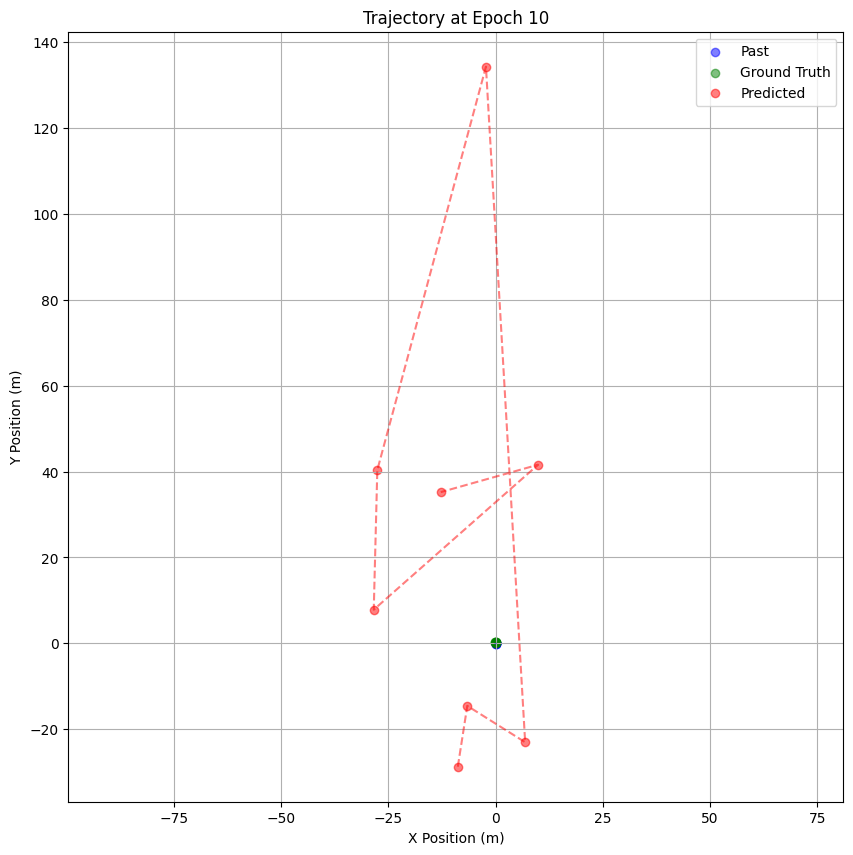

Epoch 11: 100%|██████████| 459/459 [00:02<00:00, 153.10it/s, loss=0.5793]



Epoch 11/100, Loss: 0.6275


Epoch 12: 100%|██████████| 459/459 [00:02<00:00, 157.61it/s, loss=0.5818]



Epoch 12/100, Loss: 0.5516


Epoch 13: 100%|██████████| 459/459 [00:02<00:00, 159.95it/s, loss=0.4189]



Epoch 13/100, Loss: 0.4957


Epoch 14: 100%|██████████| 459/459 [00:02<00:00, 157.07it/s, loss=0.4717]



Epoch 14/100, Loss: 0.4440


Epoch 15: 100%|██████████| 459/459 [00:03<00:00, 151.14it/s, loss=0.2818]



Epoch 15/100, Loss: 0.4015


Epoch 16: 100%|██████████| 459/459 [00:02<00:00, 157.27it/s, loss=0.3930]



Epoch 16/100, Loss: 0.3720


Epoch 17: 100%|██████████| 459/459 [00:02<00:00, 158.90it/s, loss=0.3415]



Epoch 17/100, Loss: 0.3335


Epoch 18: 100%|██████████| 459/459 [00:02<00:00, 161.94it/s, loss=0.3588]



Epoch 18/100, Loss: 0.3025


Epoch 19: 100%|██████████| 459/459 [00:02<00:00, 154.12it/s, loss=0.2893]



Epoch 19/100, Loss: 0.2807


Epoch 20: 100%|██████████| 459/459 [00:02<00:00, 153.43it/s, loss=0.2636]



Epoch 20/100, Loss: 0.2556


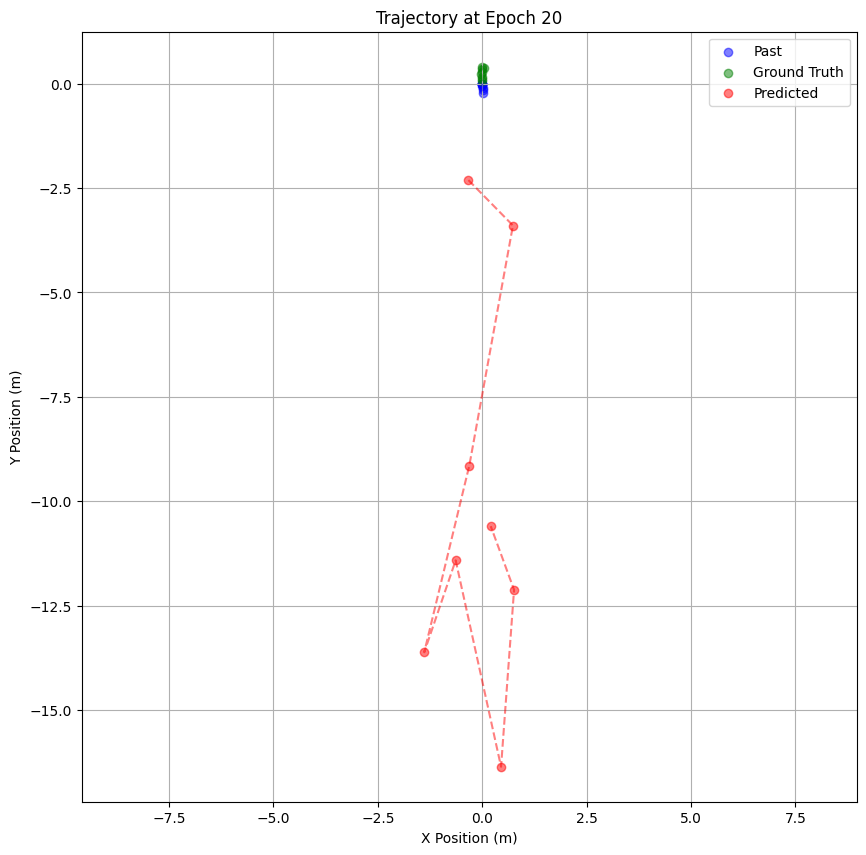

Epoch 21: 100%|██████████| 459/459 [00:02<00:00, 156.79it/s, loss=0.1595]



Epoch 21/100, Loss: 0.2337


Epoch 22: 100%|██████████| 459/459 [00:02<00:00, 153.88it/s, loss=0.2281]



Epoch 22/100, Loss: 0.2182


Epoch 23: 100%|██████████| 459/459 [00:03<00:00, 152.49it/s, loss=0.2218]



Epoch 23/100, Loss: 0.2055


Epoch 24: 100%|██████████| 459/459 [00:03<00:00, 152.54it/s, loss=0.1440]



Epoch 24/100, Loss: 0.1924


Epoch 25: 100%|██████████| 459/459 [00:02<00:00, 155.50it/s, loss=0.1176]



Epoch 25/100, Loss: 0.1793


Epoch 26: 100%|██████████| 459/459 [00:02<00:00, 161.16it/s, loss=0.1483]



Epoch 26/100, Loss: 0.1766


Epoch 27: 100%|██████████| 459/459 [00:02<00:00, 155.61it/s, loss=0.1172]



Epoch 27/100, Loss: 0.1748


Epoch 28: 100%|██████████| 459/459 [00:03<00:00, 153.00it/s, loss=0.1897]



Epoch 28/100, Loss: 0.1661


Epoch 29: 100%|██████████| 459/459 [00:02<00:00, 159.10it/s, loss=0.1015]



Epoch 29/100, Loss: 0.1653


Epoch 30: 100%|██████████| 459/459 [00:02<00:00, 159.76it/s, loss=0.1865]



Epoch 30/100, Loss: 0.1583


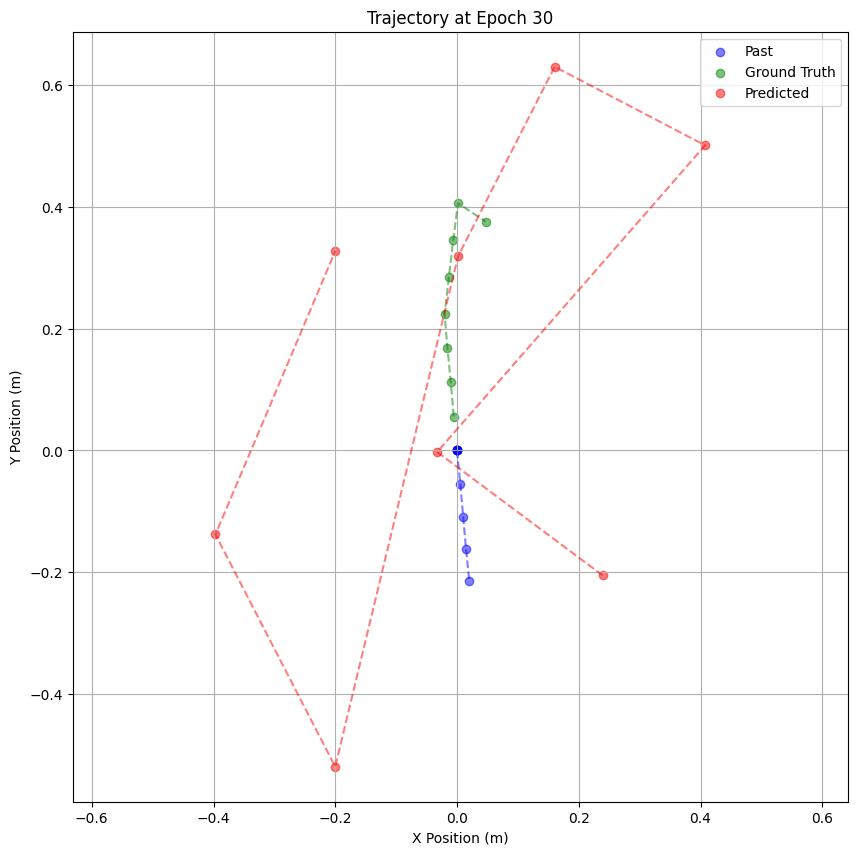

Epoch 31: 100%|██████████| 459/459 [00:02<00:00, 155.62it/s, loss=0.1004]



Epoch 31/100, Loss: 0.1556


Epoch 32: 100%|██████████| 459/459 [00:03<00:00, 152.21it/s, loss=0.1656]



Epoch 32/100, Loss: 0.1543


Epoch 33: 100%|██████████| 459/459 [00:02<00:00, 156.90it/s, loss=0.0934]



Epoch 33/100, Loss: 0.1487


Epoch 34: 100%|██████████| 459/459 [00:02<00:00, 155.51it/s, loss=0.1700]



Epoch 34/100, Loss: 0.1458


Epoch 35: 100%|██████████| 459/459 [00:02<00:00, 156.49it/s, loss=0.2166]



Epoch 35/100, Loss: 0.1420


Epoch 36: 100%|██████████| 459/459 [00:02<00:00, 155.15it/s, loss=0.1290]



Epoch 36/100, Loss: 0.1432


Epoch 37: 100%|██████████| 459/459 [00:03<00:00, 152.64it/s, loss=0.1505]



Epoch 37/100, Loss: 0.1423


Epoch 38: 100%|██████████| 459/459 [00:02<00:00, 158.05it/s, loss=0.2250]



Epoch 38/100, Loss: 0.1403


Epoch 39: 100%|██████████| 459/459 [00:02<00:00, 155.72it/s, loss=0.1866]



Epoch 39/100, Loss: 0.1329


Epoch 40: 100%|██████████| 459/459 [00:02<00:00, 155.90it/s, loss=0.0372]



Epoch 40/100, Loss: 0.1355


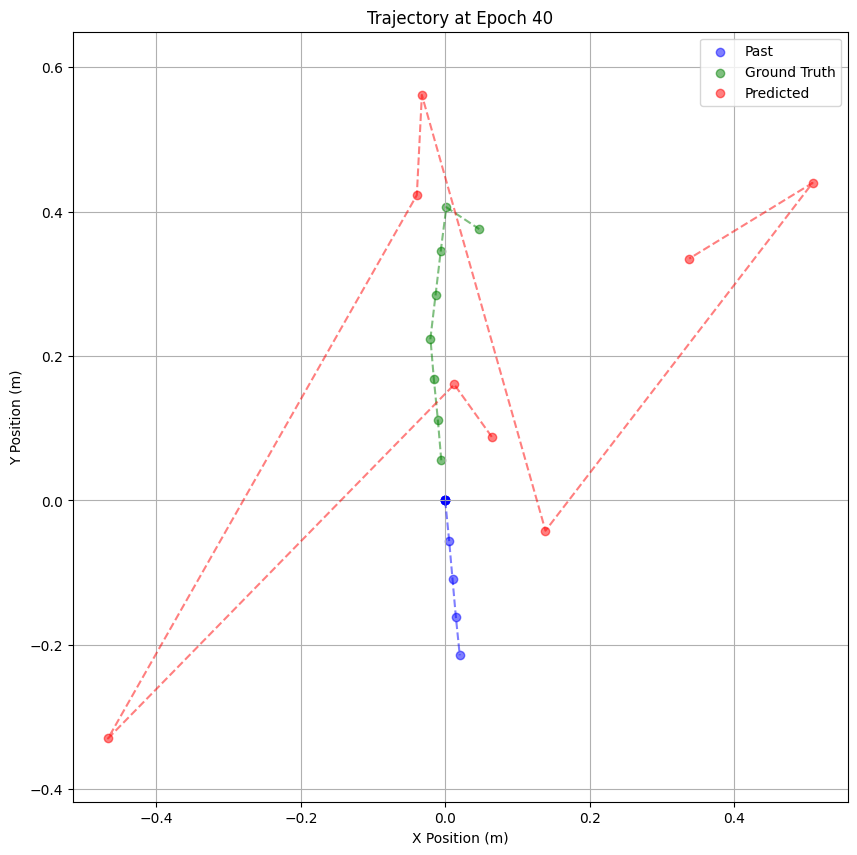

Epoch 41: 100%|██████████| 459/459 [00:03<00:00, 149.72it/s, loss=0.1120]



Epoch 41/100, Loss: 0.1336


Epoch 42: 100%|██████████| 459/459 [00:02<00:00, 153.96it/s, loss=0.0922]



Epoch 42/100, Loss: 0.1323


Epoch 43: 100%|██████████| 459/459 [00:02<00:00, 155.25it/s, loss=0.1394]



Epoch 43/100, Loss: 0.1296


Epoch 44: 100%|██████████| 459/459 [00:02<00:00, 159.29it/s, loss=0.1361]



Epoch 44/100, Loss: 0.1271


Epoch 45: 100%|██████████| 459/459 [00:03<00:00, 149.28it/s, loss=0.1075]



Epoch 45/100, Loss: 0.1294


Epoch 46: 100%|██████████| 459/459 [00:03<00:00, 151.92it/s, loss=0.1309]



Epoch 46/100, Loss: 0.1288


Epoch 47: 100%|██████████| 459/459 [00:02<00:00, 155.25it/s, loss=0.1593]



Epoch 47/100, Loss: 0.1261


Epoch 48: 100%|██████████| 459/459 [00:02<00:00, 158.02it/s, loss=0.0729]



Epoch 48/100, Loss: 0.1266


Epoch 49: 100%|██████████| 459/459 [00:03<00:00, 146.66it/s, loss=0.1628]



Epoch 49/100, Loss: 0.1245


Epoch 50: 100%|██████████| 459/459 [00:03<00:00, 148.84it/s, loss=0.1321]



Epoch 50/100, Loss: 0.1231


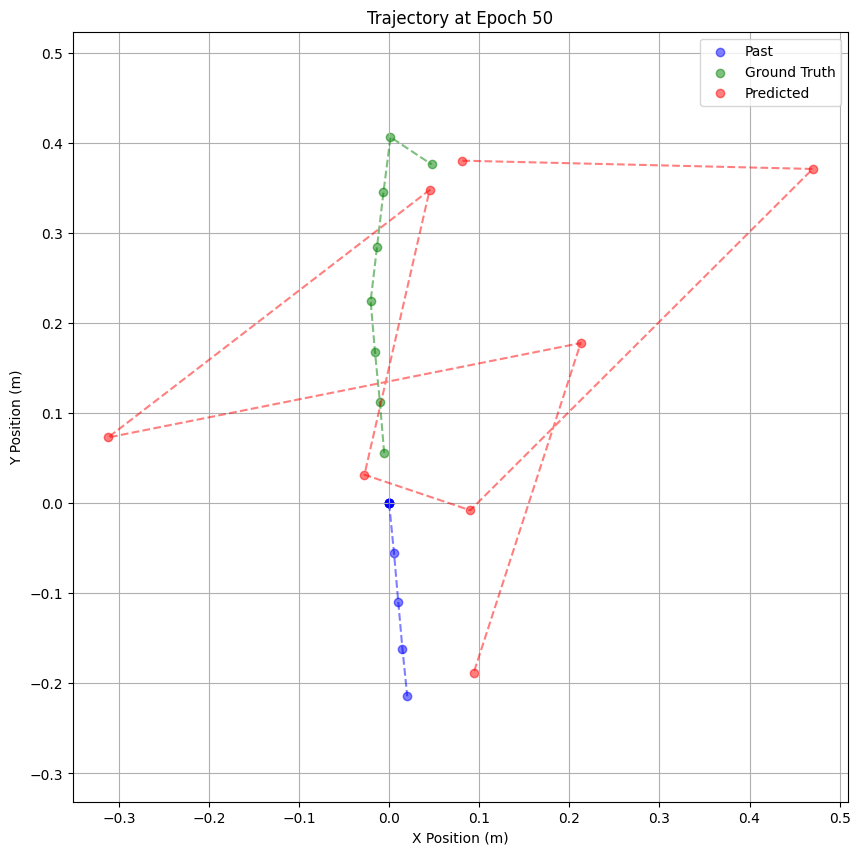

Epoch 51: 100%|██████████| 459/459 [00:02<00:00, 153.95it/s, loss=0.1112]



Epoch 51/100, Loss: 0.1207


Epoch 52: 100%|██████████| 459/459 [00:03<00:00, 150.40it/s, loss=0.1569]



Epoch 52/100, Loss: 0.1232


Epoch 53: 100%|██████████| 459/459 [00:03<00:00, 147.86it/s, loss=0.0772]



Epoch 53/100, Loss: 0.1196


Epoch 54: 100%|██████████| 459/459 [00:03<00:00, 144.49it/s, loss=0.1345]



Epoch 54/100, Loss: 0.1244


Epoch 55: 100%|██████████| 459/459 [00:02<00:00, 153.08it/s, loss=0.2050]



Epoch 55/100, Loss: 0.1176


Epoch 56: 100%|██████████| 459/459 [00:03<00:00, 150.18it/s, loss=0.1440]



Epoch 56/100, Loss: 0.1180


Epoch 57: 100%|██████████| 459/459 [00:03<00:00, 149.78it/s, loss=0.1088]



Epoch 57/100, Loss: 0.1190


Epoch 58: 100%|██████████| 459/459 [00:03<00:00, 145.40it/s, loss=0.0766]



Epoch 58/100, Loss: 0.1173


Epoch 59: 100%|██████████| 459/459 [00:02<00:00, 155.92it/s, loss=0.1119]



Epoch 59/100, Loss: 0.1142


Epoch 60: 100%|██████████| 459/459 [00:02<00:00, 154.95it/s, loss=0.1510]



Epoch 60/100, Loss: 0.1173


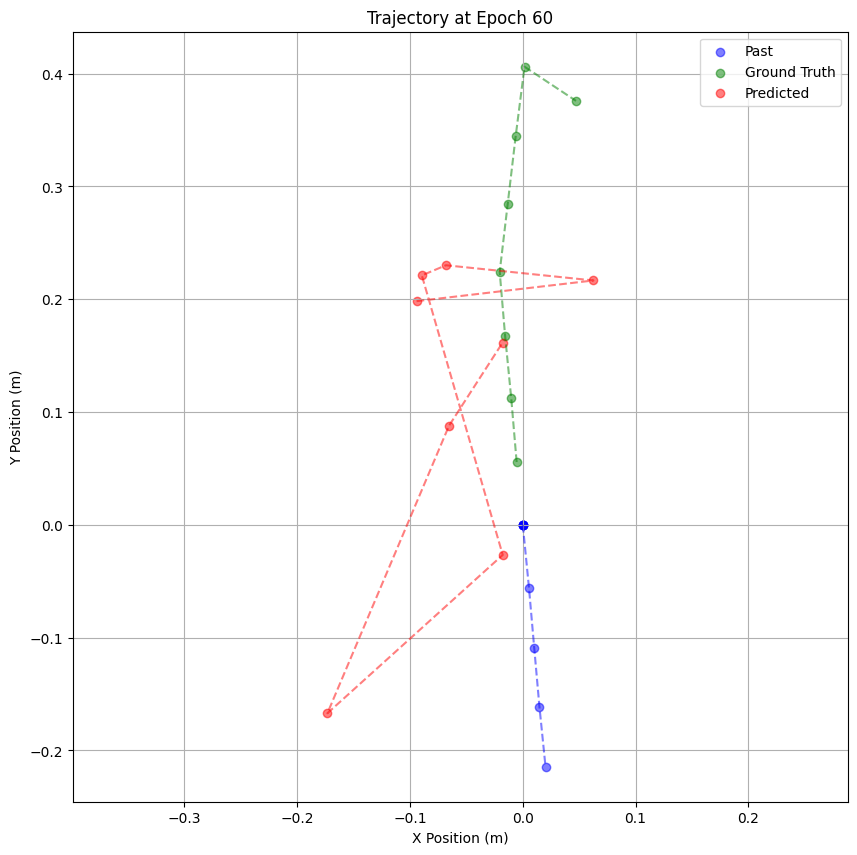

Epoch 61: 100%|██████████| 459/459 [00:02<00:00, 153.57it/s, loss=0.0974]



Epoch 61/100, Loss: 0.1157


Epoch 62: 100%|██████████| 459/459 [00:03<00:00, 145.84it/s, loss=0.1786]



Epoch 62/100, Loss: 0.1174


Epoch 63: 100%|██████████| 459/459 [00:02<00:00, 153.93it/s, loss=0.1211]



Epoch 63/100, Loss: 0.1150


Epoch 64: 100%|██████████| 459/459 [00:02<00:00, 154.42it/s, loss=0.0538]



Epoch 64/100, Loss: 0.1128


Epoch 65: 100%|██████████| 459/459 [00:02<00:00, 158.45it/s, loss=0.1860]



Epoch 65/100, Loss: 0.1174


Epoch 66: 100%|██████████| 459/459 [00:02<00:00, 153.49it/s, loss=0.1234]



Epoch 66/100, Loss: 0.1115


Epoch 67: 100%|██████████| 459/459 [00:03<00:00, 151.29it/s, loss=0.1225]



Epoch 67/100, Loss: 0.1135


Epoch 68: 100%|██████████| 459/459 [00:02<00:00, 155.58it/s, loss=0.1349]



Epoch 68/100, Loss: 0.1106


Epoch 69: 100%|██████████| 459/459 [00:02<00:00, 156.94it/s, loss=0.0895]



Epoch 69/100, Loss: 0.1147


Epoch 70: 100%|██████████| 459/459 [00:02<00:00, 154.59it/s, loss=0.0985]



Epoch 70/100, Loss: 0.1107


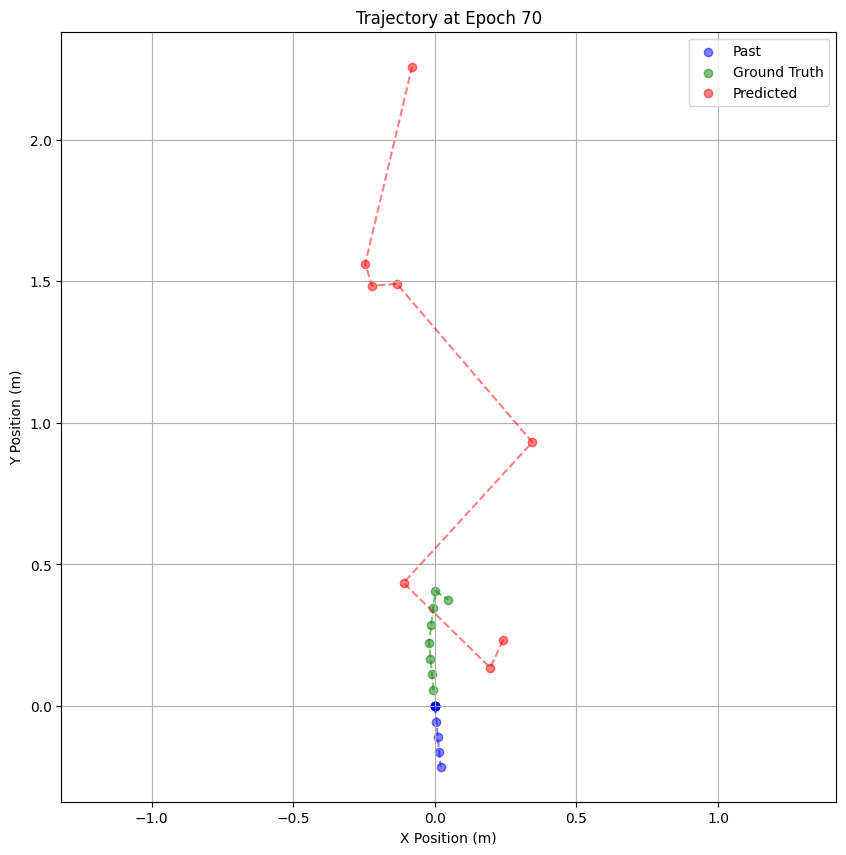

Epoch 71: 100%|██████████| 459/459 [00:03<00:00, 150.26it/s, loss=0.0847]



Epoch 71/100, Loss: 0.1119


Epoch 72: 100%|██████████| 459/459 [00:03<00:00, 152.24it/s, loss=0.1046]



Epoch 72/100, Loss: 0.1116


Epoch 73: 100%|██████████| 459/459 [00:02<00:00, 155.18it/s, loss=0.0598]



Epoch 73/100, Loss: 0.1117


Epoch 74: 100%|██████████| 459/459 [00:02<00:00, 155.55it/s, loss=0.1346]



Epoch 74/100, Loss: 0.1094


Epoch 75: 100%|██████████| 459/459 [00:03<00:00, 148.96it/s, loss=0.1292]



Epoch 75/100, Loss: 0.1102


Epoch 76: 100%|██████████| 459/459 [00:02<00:00, 154.51it/s, loss=0.1276]



Epoch 76/100, Loss: 0.1092


Epoch 77: 100%|██████████| 459/459 [00:02<00:00, 157.42it/s, loss=0.1013]



Epoch 77/100, Loss: 0.1116


Epoch 78: 100%|██████████| 459/459 [00:02<00:00, 153.84it/s, loss=0.1384]



Epoch 78/100, Loss: 0.1084


Epoch 79: 100%|██████████| 459/459 [00:03<00:00, 151.45it/s, loss=0.1275]



Epoch 79/100, Loss: 0.1090


Epoch 80: 100%|██████████| 459/459 [00:03<00:00, 151.14it/s, loss=0.0840]



Epoch 80/100, Loss: 0.1066


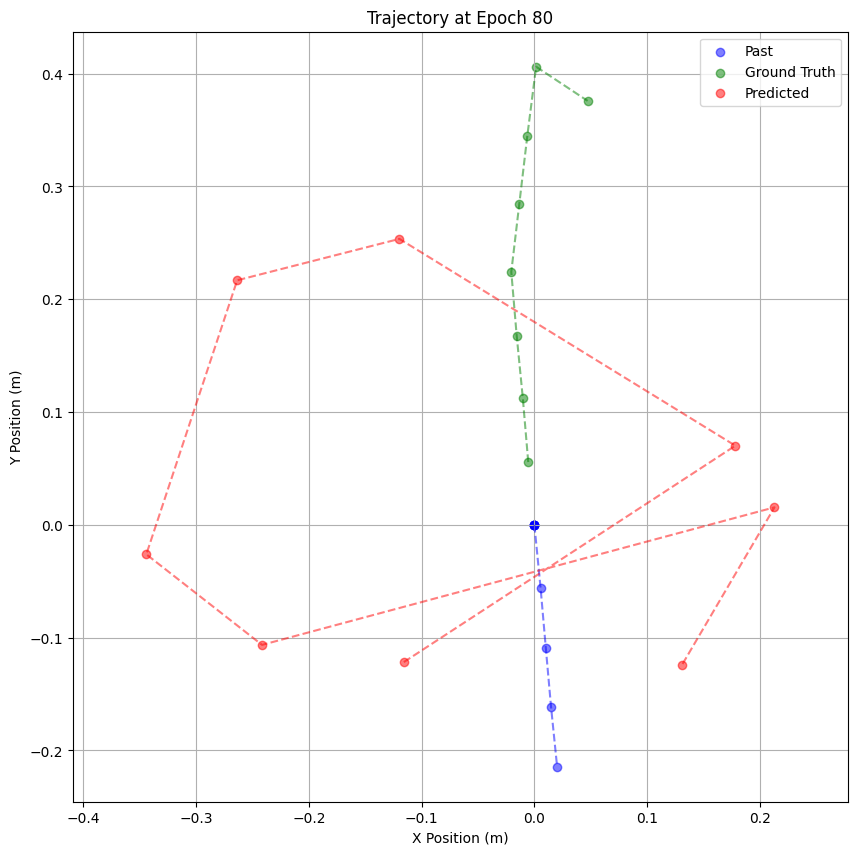

Epoch 81: 100%|██████████| 459/459 [00:02<00:00, 153.61it/s, loss=0.1748]



Epoch 81/100, Loss: 0.1037


Epoch 82: 100%|██████████| 459/459 [00:03<00:00, 150.60it/s, loss=0.1223]



Epoch 82/100, Loss: 0.1058


Epoch 83: 100%|██████████| 459/459 [00:03<00:00, 151.30it/s, loss=0.0624]



Epoch 83/100, Loss: 0.1051


Epoch 84: 100%|██████████| 459/459 [00:03<00:00, 152.39it/s, loss=0.1092]



Epoch 84/100, Loss: 0.1080


Epoch 85: 100%|██████████| 459/459 [00:02<00:00, 154.64it/s, loss=0.1313]



Epoch 85/100, Loss: 0.1078


Epoch 86: 100%|██████████| 459/459 [00:02<00:00, 155.62it/s, loss=0.0747]



Epoch 86/100, Loss: 0.1075


Epoch 87: 100%|██████████| 459/459 [00:02<00:00, 153.68it/s, loss=0.0718]



Epoch 87/100, Loss: 0.1054


Epoch 88: 100%|██████████| 459/459 [00:03<00:00, 144.29it/s, loss=0.0670]



Epoch 88/100, Loss: 0.1054


Epoch 89: 100%|██████████| 459/459 [00:03<00:00, 150.30it/s, loss=0.1301]



Epoch 89/100, Loss: 0.1068


Epoch 90: 100%|██████████| 459/459 [00:03<00:00, 151.71it/s, loss=0.1452]



Epoch 90/100, Loss: 0.1052


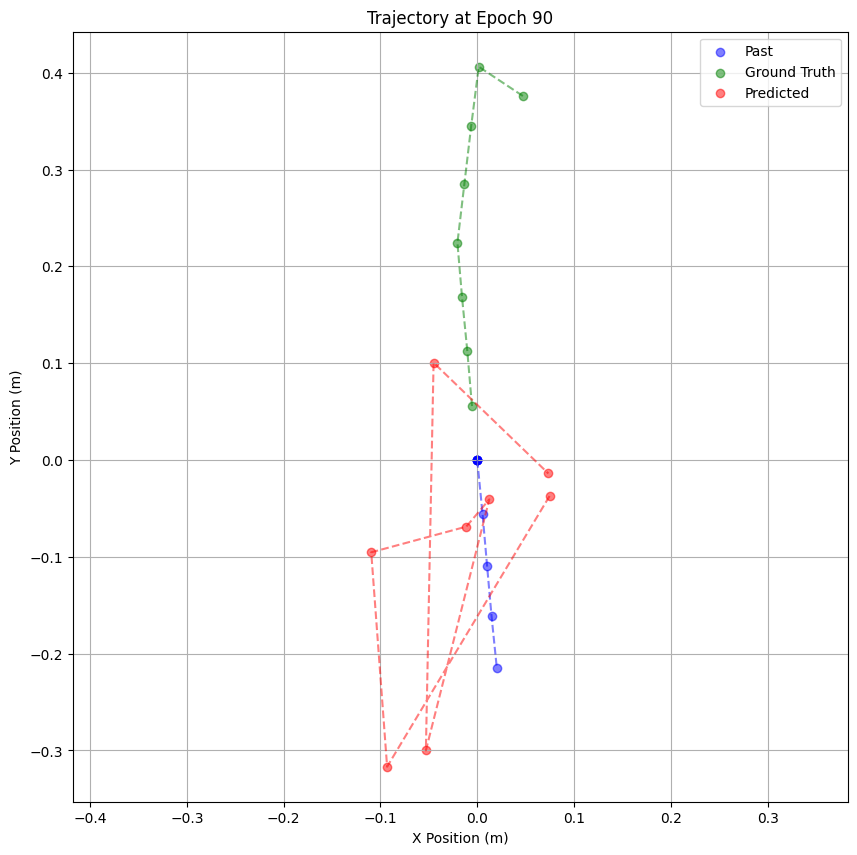

Epoch 91: 100%|██████████| 459/459 [00:02<00:00, 156.52it/s, loss=0.1078]



Epoch 91/100, Loss: 0.1031


Epoch 92: 100%|██████████| 459/459 [00:03<00:00, 148.00it/s, loss=0.1073]



Epoch 92/100, Loss: 0.1039


Epoch 93: 100%|██████████| 459/459 [00:02<00:00, 153.87it/s, loss=0.0778]



Epoch 93/100, Loss: 0.1035


Epoch 94: 100%|██████████| 459/459 [00:03<00:00, 150.59it/s, loss=0.1101]



Epoch 94/100, Loss: 0.1007


Epoch 95: 100%|██████████| 459/459 [00:03<00:00, 148.80it/s, loss=0.0933]



Epoch 95/100, Loss: 0.1018


Epoch 96: 100%|██████████| 459/459 [00:03<00:00, 145.37it/s, loss=0.1082]



Epoch 96/100, Loss: 0.1028


Epoch 97: 100%|██████████| 459/459 [00:03<00:00, 144.95it/s, loss=0.1630]



Epoch 97/100, Loss: 0.1010


Epoch 98: 100%|██████████| 459/459 [00:02<00:00, 154.59it/s, loss=0.1219]



Epoch 98/100, Loss: 0.1043


Epoch 99: 100%|██████████| 459/459 [00:03<00:00, 152.89it/s, loss=0.0622]



Epoch 99/100, Loss: 0.1027


Epoch 100: 100%|██████████| 459/459 [00:03<00:00, 147.76it/s, loss=0.0600]



Epoch 100/100, Loss: 0.1020


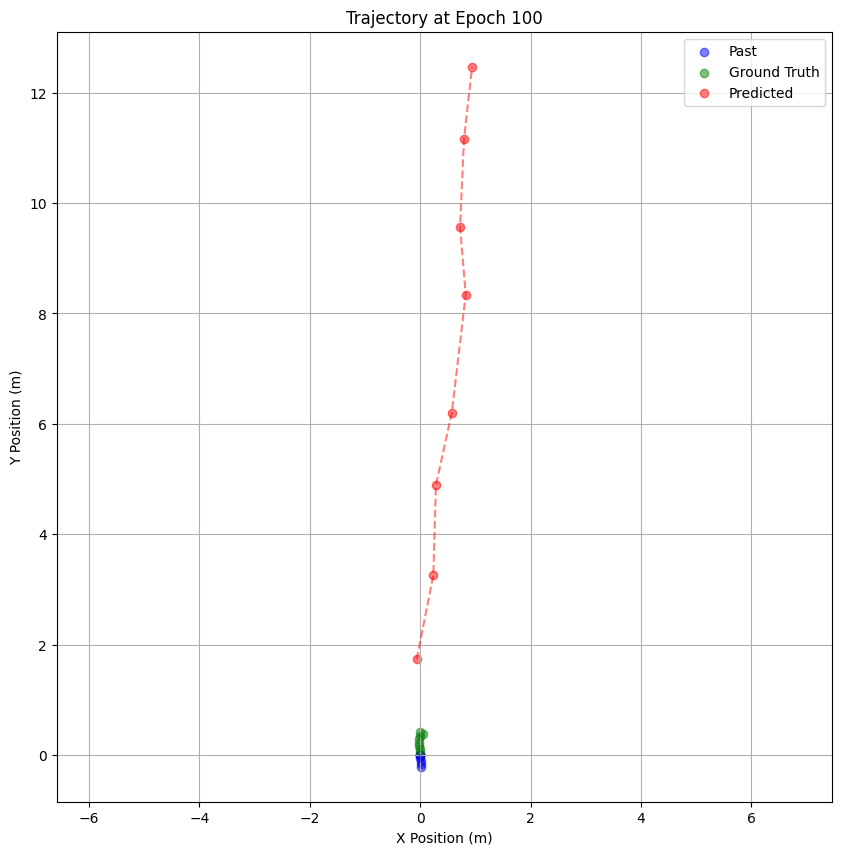

In [9]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from typing import Dict, List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import numpy as np
from torch.utils.data import Dataset
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from typing import Dict, List, Tuple

class VehicleTrajectoryDataset(Dataset):
    def __init__(self,
                 nusc: NuScenes,
                 helper: PredictHelper,
                 history_seconds: float = 2.0,
                 future_seconds: float = 4.0,
                 history_freq: float = 5.0,  # 5Hz
                 future_freq: float = 2.0,   # 2Hz
                 min_movement: float = 1.0,  # meters
                 max_vehicle_speed: float = 30.0):  # m/s (~108 km/h)

        self.nusc = nusc
        self.helper = helper
        self.history_seconds = history_seconds
        self.future_seconds = future_seconds
        self.history_freq = history_freq
        self.future_freq = future_freq
        self.min_movement = min_movement
        self.max_vehicle_speed = max_vehicle_speed

        # Calculate number of steps
        self.history_steps = int(history_seconds * history_freq)
        self.future_steps = int(future_seconds * future_freq)

        # Vehicle categories in nuScenes
        self.vehicle_categories = [
            'vehicle.car',
            'vehicle.truck',
            'vehicle.bus',
            'vehicle.trailer'
        ]

        # Collect valid vehicle trajectories
        self.valid_samples = self._collect_valid_samples()
        print(f"Found {len(self.valid_samples)} valid vehicle trajectories")

    def _collect_valid_samples(self) -> List[Dict]:
        valid_samples = []
        total_samples = 0
        filtered_counts = {
            'non_vehicle': 0,
            'insufficient_history': 0,
            'insufficient_future': 0,
            'static': 0,
            'invalid_velocity': 0
        }

        for scene in self.nusc.scene:
            sample_token = scene['first_sample_token']

            while sample_token:
                sample = self.nusc.get('sample', sample_token)

                for ann_token in sample['anns']:
                    total_samples += 1
                    ann = self.nusc.get('sample_annotation', ann_token)

                    # Check if it's a vehicle
                    if not any(ann['category_name'].startswith(cat) for cat in self.vehicle_categories):
                        filtered_counts['non_vehicle'] += 1
                        continue

                    try:
                        # Get trajectories
                        past = self.helper.get_past_for_agent(
                            ann['instance_token'],
                            sample_token,
                            seconds=self.history_seconds,
                            in_agent_frame=True
                        )

                        future = self.helper.get_future_for_agent(
                            ann['instance_token'],
                            sample_token,
                            seconds=self.future_seconds,
                            in_agent_frame=True
                        )

                        # Apply filtering criteria
                        if len(past) < self.history_steps * 0.5:
                            filtered_counts['insufficient_history'] += 1
                            continue

                        if len(future) < self.future_steps * 0.5:
                            filtered_counts['insufficient_future'] += 1
                            continue

                        # Check if vehicle is moving
                        total_movement = np.linalg.norm(future[-1] - past[0])
                        if total_movement < self.min_movement:
                            filtered_counts['static'] += 1
                            continue

                        # Check for valid velocities
                        max_step_dist = self.max_vehicle_speed * (1.0/self.history_freq)

                        valid_velocity = True
                        for i in range(1, len(past)):
                            if np.linalg.norm(past[i] - past[i-1]) > max_step_dist:
                                valid_velocity = False
                                break

                        for i in range(1, len(future)):
                            if np.linalg.norm(future[i] - future[i-1]) > max_step_dist:
                                valid_velocity = False
                                break

                        if not valid_velocity:
                            filtered_counts['invalid_velocity'] += 1
                            continue

                        # If all checks pass, add to valid samples
                        valid_samples.append({
                            'sample_token': sample_token,
                            'instance_token': ann['instance_token'],
                            'category': ann['category_name']
                        })

                    except Exception as e:
                        print(f"Error processing sample {sample_token}: {e}")
                        continue

                sample_token = sample['next']

        # Print filtering statistics
        print("\nTrajectory Filtering Statistics:")
        print(f"Total samples processed: {total_samples}")
        for reason, count in filtered_counts.items():
            print(f"Filtered {reason}: {count} ({count/total_samples*100:.1f}%)")
        print(f"Valid samples: {len(valid_samples)} ({len(valid_samples)/total_samples*100:.1f}%)")

        return valid_samples

    def __len__(self) -> int:
        return len(self.valid_samples)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        sample = self.valid_samples[idx]

        # Get trajectories
        past = self.helper.get_past_for_agent(
            sample['instance_token'],
            sample['sample_token'],
            seconds=self.history_seconds,
            in_agent_frame=True
        )

        future = self.helper.get_future_for_agent(
            sample['instance_token'],
            sample['sample_token'],
            seconds=self.future_seconds,
            in_agent_frame=True
        )

        # Convert to tensors with fixed size
        past_tensor = torch.zeros(self.history_steps, 2)
        if len(past) > 0:
            past_tensor[-len(past):] = torch.tensor(past)

        future_tensor = torch.zeros(self.future_steps, 2)
        if len(future) > 0:
            future_tensor[:len(future)] = torch.tensor(future)

        return {
            'past': past_tensor,
            'future': future_tensor,
            'category': sample['category']
        }

class DiffusionModel(nn.Module):
    def __init__(self,
                 history_steps: int,
                 future_steps: int,
                 hidden_size: int = 256,
                 num_diffusion_steps: int = 1000):
        super().__init__()
        self.history_steps = history_steps
        self.future_steps = future_steps
        self.num_diffusion_steps = num_diffusion_steps

        # Encoder for past trajectory
        self.history_encoder = nn.Sequential(
            nn.Linear(history_steps * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size + hidden_size + future_steps * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, future_steps * 2)
        )

        # Setup noise schedule
        betas = torch.linspace(1e-4, 0.02, num_diffusion_steps)
        alphas = 1 - betas
        self.register_buffer('alphas_cumprod', torch.cumprod(alphas, dim=0))

    def forward(self, history: torch.Tensor, noisy_future: torch.Tensor,
                timesteps: torch.Tensor) -> torch.Tensor:
        # Encode history
        history_feat = self.history_encoder(history.reshape(history.shape[0], -1))

        # Embed timesteps
        time_feat = self.time_embed(timesteps.unsqueeze(-1).float())

        # Combine features
        combined = torch.cat([
            history_feat,
            time_feat,
            noisy_future.reshape(noisy_future.shape[0], -1)
        ], dim=-1)

        # Predict noise
        pred_noise = self.decoder(combined)
        return pred_noise.reshape(noisy_future.shape)

def visualize_trajectories(past: torch.Tensor,
                         future: torch.Tensor,
                         predicted: torch.Tensor,
                         title: str = "Trajectory Visualization"):
    """Visualize actual and predicted trajectories."""
    plt.figure(figsize=(10, 10))

    # Plot past trajectory
    plt.scatter(past[:, 0], past[:, 1], c='blue', label='Past', alpha=0.5)
    plt.plot(past[:, 0], past[:, 1], 'b--', alpha=0.5)

    # Plot ground truth future
    plt.scatter(future[:, 0], future[:, 1], c='green', label='Ground Truth', alpha=0.5)
    plt.plot(future[:, 0], future[:, 1], 'g--', alpha=0.5)

    # Plot predicted trajectories
    plt.scatter(predicted[:, 0], predicted[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.plot(predicted[:, 0], predicted[:, 1], 'r--', alpha=0.5)

    plt.title(title)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

def sample_trajectories(model: nn.Module,
                       past: torch.Tensor,
                       num_steps: int = 1000,
                       device: torch.device = None) -> torch.Tensor:
    """Sample trajectories using the diffusion model."""
    model.eval()
    batch_size = past.shape[0]

    # Start from random noise
    x = torch.randn(batch_size, model.future_steps, 2, device=device)

    # Gradually denoise
    for t in tqdm(reversed(range(num_steps)), desc="Sampling", leave=False):
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)

        # Predict noise
        with torch.no_grad():
            predicted_noise = model(past, x, t_batch)

        # Update sample
        alpha = model.alphas_cumprod[t]
        alpha_prev = model.alphas_cumprod[t-1] if t > 0 else torch.tensor(1.0)
        beta = 1 - alpha/alpha_prev

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / torch.sqrt(1 - beta)) * (x - beta / torch.sqrt(1 - alpha) * predicted_noise) + \
            torch.sqrt(beta) * noise

    return x

def train_epoch(model: nn.Module,
                dataloader: DataLoader,
                optimizer: torch.optim.Optimizer,
                device: torch.device,
                epoch: int) -> float:
    model.train()
    total_loss = 0

    # Create progress bar
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=True)

    for batch in pbar:
        # Get data
        past = batch['past'].to(device)
        future = batch['future'].to(device)

        # Sample random timesteps
        t = torch.randint(0, model.num_diffusion_steps, (past.shape[0],), device=device)

        # Add noise to future trajectory
        noise = torch.randn_like(future)
        alphas_cumprod_t = model.alphas_cumprod[t]
        noisy_future = torch.sqrt(alphas_cumprod_t.unsqueeze(-1).unsqueeze(-1)) * future + \
                      torch.sqrt(1 - alphas_cumprod_t.unsqueeze(-1).unsqueeze(-1)) * noise

        # Predict noise
        pred_noise = model(past, noisy_future, t)

        # Calculate loss
        loss = torch.nn.functional.mse_loss(pred_noise, noise)

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(dataloader)

def main():
    # Initialize NuScenes
    dataroot = "/content/drive/MyDrive/v1.0-mini 2" # Adjust this to your actual path
    nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)
    helper = PredictHelper(nusc)

    # Create dataset and dataloader
    dataset = TrajectoryDataset(nusc, helper)
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        num_workers=4
    )

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = DiffusionModel(
        history_steps=int(2.0 * 5),  # 2 seconds at 2Hz
        future_steps=int(4.0 * 2)    # 6 seconds at 2Hz
    ).to(device)

    # Setup optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training loop
    num_epochs = 100
    best_loss = float('inf')

    # Get one batch for visualization
    vis_batch = next(iter(dataloader))
    vis_past = vis_batch['past'][:1].to(device)  # Take first trajectory
    vis_future = vis_batch['future'][:1].to(device)

    for epoch in range(num_epochs):
        # Train one epoch
        loss = train_epoch(model, dataloader, optimizer, device, epoch)
        print(f"\nEpoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

        # Generate and visualize sample trajectory every 10 epochs
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                predicted = sample_trajectories(
                    model,
                    vis_past,
                    num_steps=model.num_diffusion_steps,
                    device=device
                )

                # Visualize
                visualize_trajectories(
                    vis_past[0].cpu().numpy(),
                    vis_future[0].cpu().numpy(),
                    predicted[0].cpu().numpy(),
                    f"Trajectory at Epoch {epoch+1}"
                )

        # Save best model
        if loss < best_loss:
            best_loss = loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, 'best_diffusion_model.pt')

if __name__ == "__main__":
    main()

Loading NuScenes tables for version v1.0-mini...


<ipython-input-10-a1e4018ae823>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.759 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Found 14688 valid trajectories


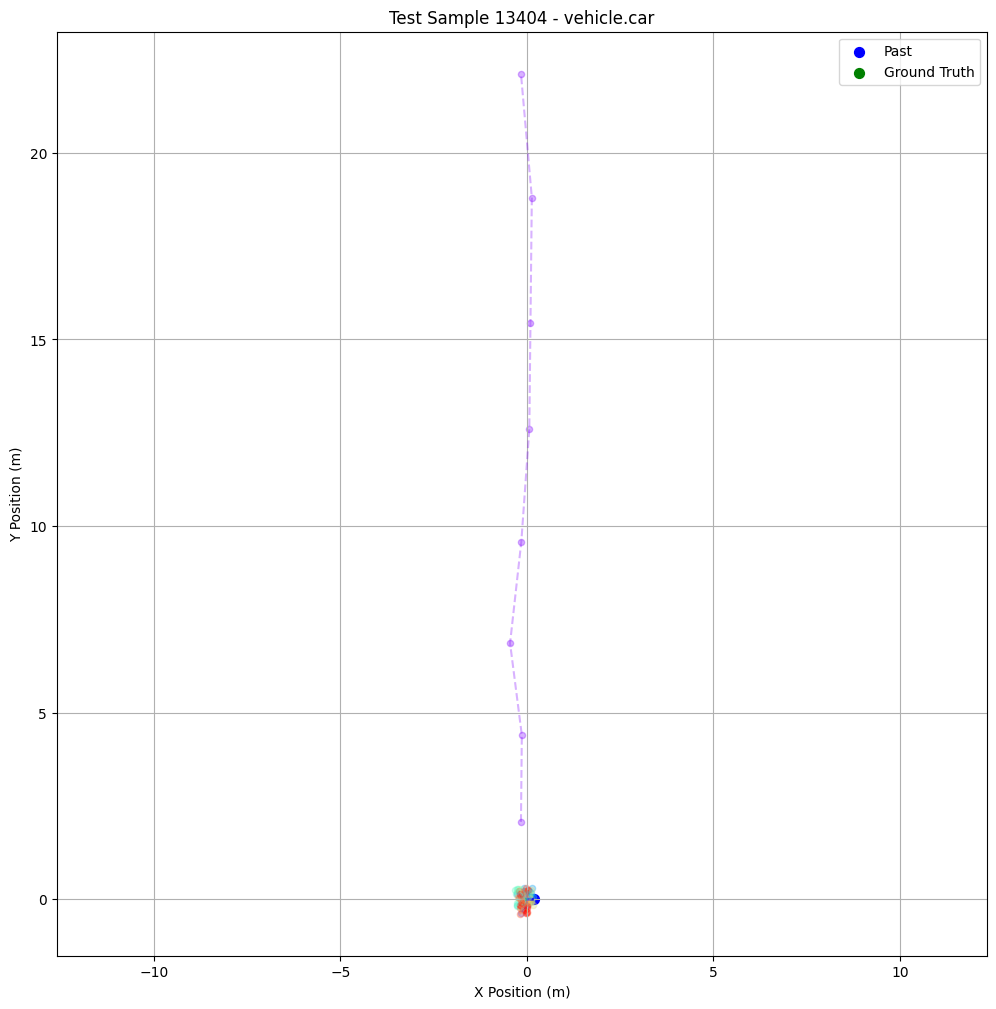


Test Sample 13404:
Category: vehicle.car
Mean Final Displacement Error: 2.42m
Min Final Displacement Error: 0.04m
Max Final Displacement Error: 22.12m


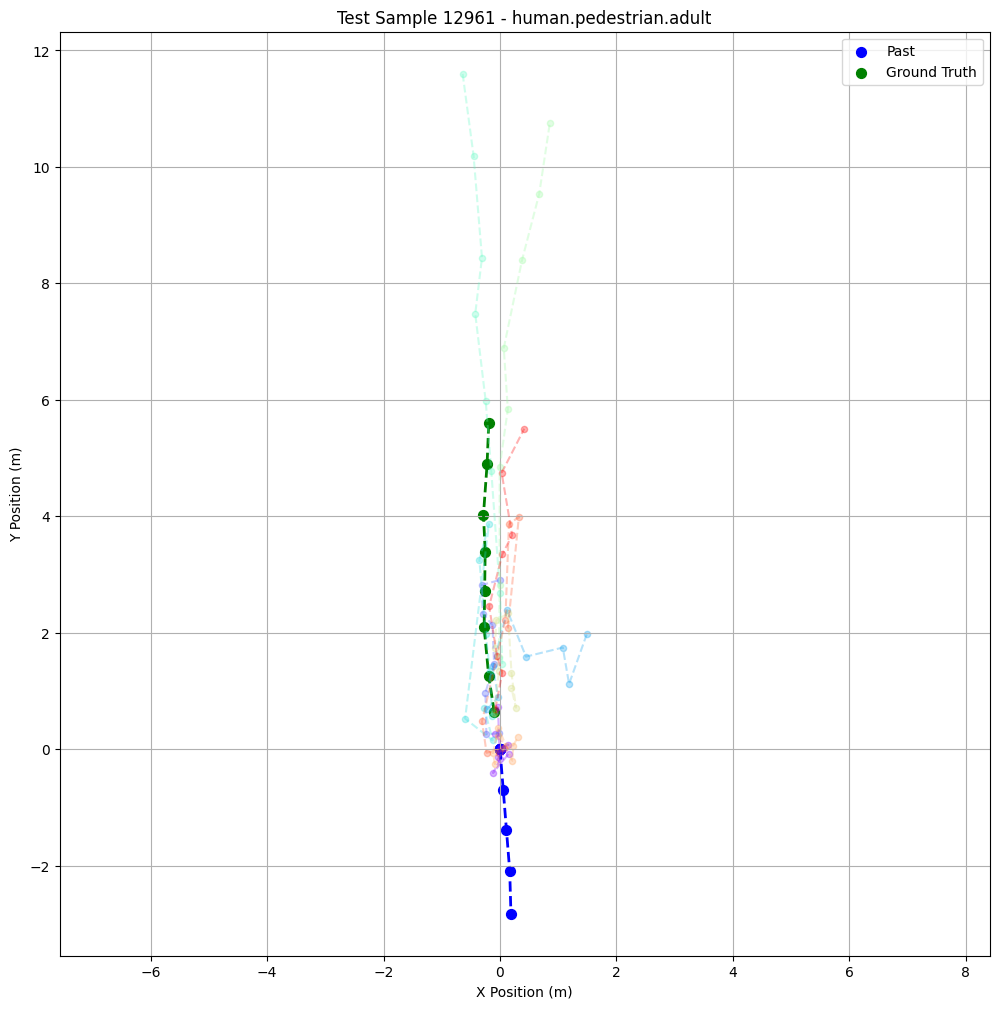


Test Sample 12961:
Category: human.pedestrian.adult
Mean Final Displacement Error: 4.45m
Min Final Displacement Error: 0.62m
Max Final Displacement Error: 6.01m


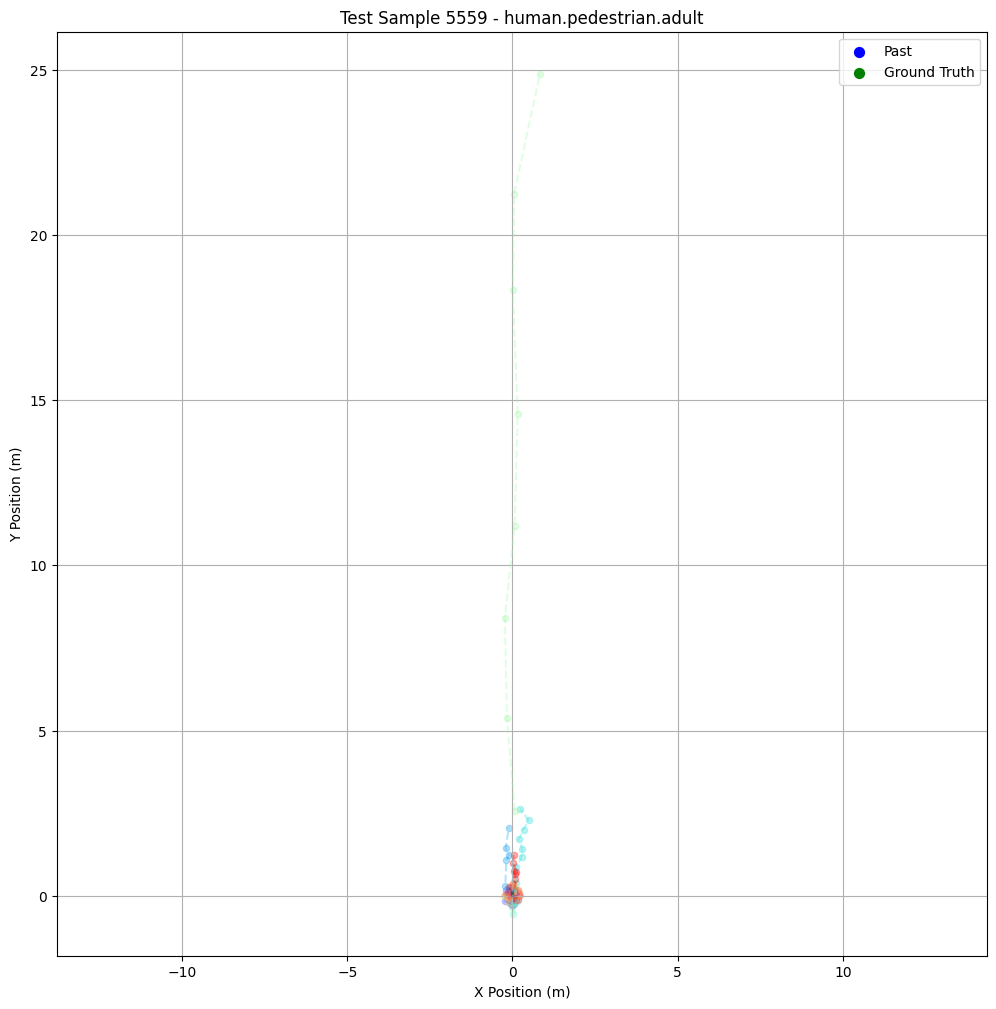


Test Sample 5559:
Category: human.pedestrian.adult
Mean Final Displacement Error: 3.19m
Min Final Displacement Error: 0.08m
Max Final Displacement Error: 24.86m


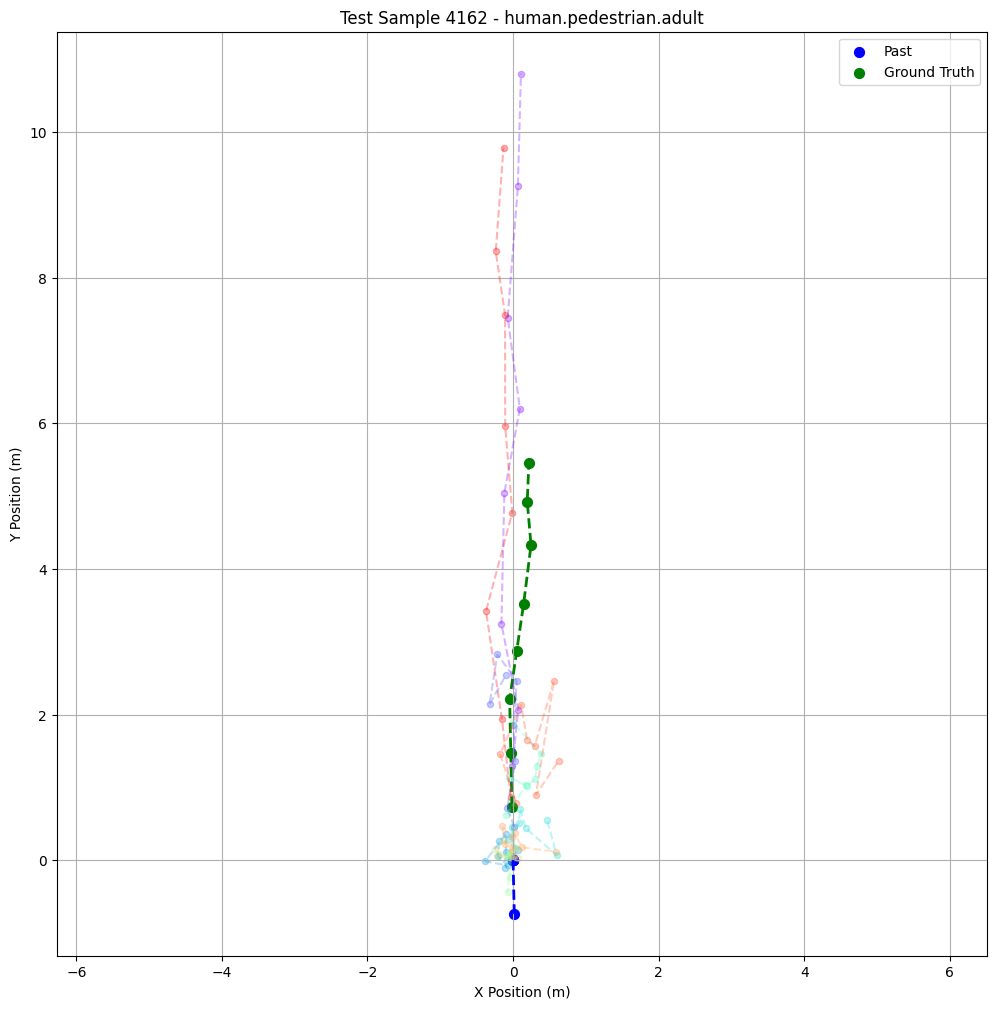


Test Sample 4162:
Category: human.pedestrian.adult
Mean Final Displacement Error: 4.67m
Min Final Displacement Error: 2.93m
Max Final Displacement Error: 5.41m


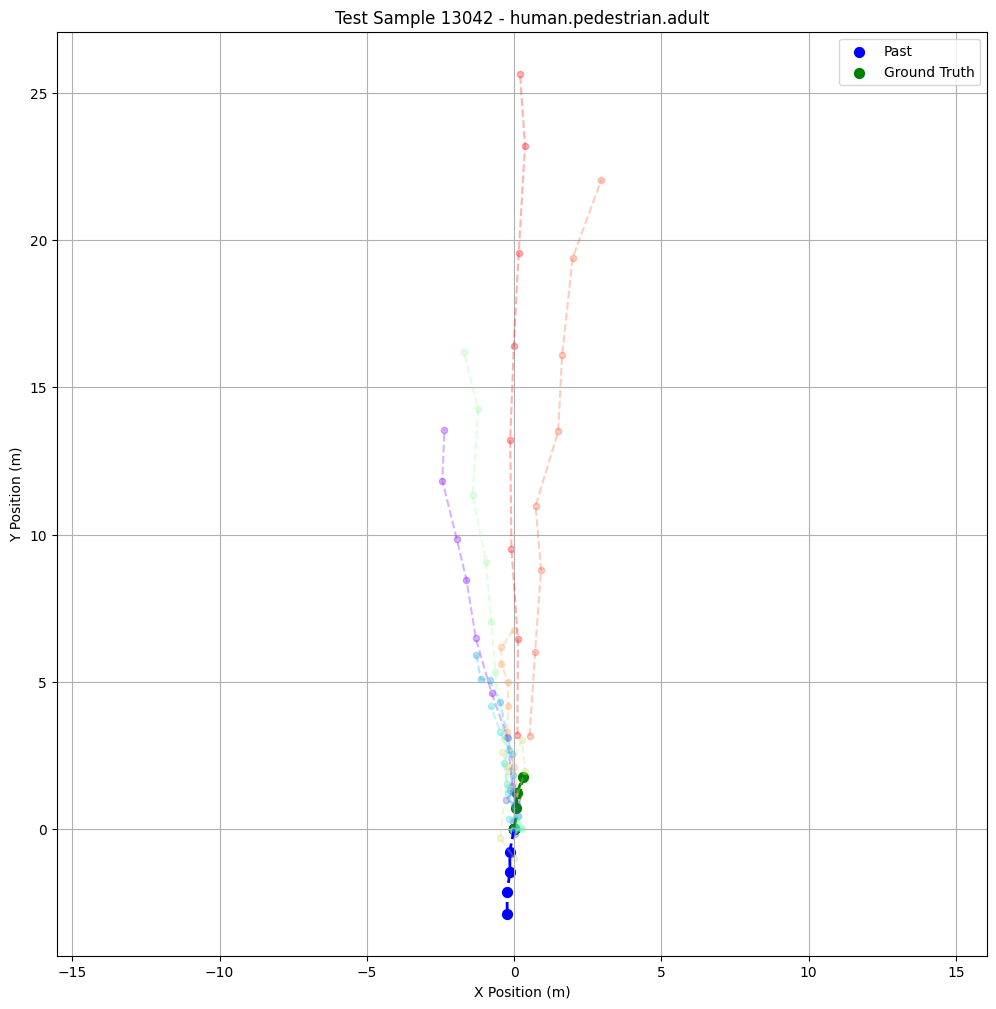


Test Sample 13042:
Category: human.pedestrian.adult
Mean Final Displacement Error: 9.77m
Min Final Displacement Error: 0.38m
Max Final Displacement Error: 25.65m


In [10]:
import torch
import matplotlib.pyplot as plt
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
import numpy as np
from typing import List

def load_trained_model(model_path: "/content/best_diffusion_model.pt", device: torch.device) -> DiffusionModel:
    """Load the trained model."""
    # Initialize model with same parameters as training
    model = DiffusionModel(
        history_steps=int(2.0 * 5),  # 2 seconds at 2Hz
        future_steps=int(4.0 * 2)    # 6 seconds at 2Hz
    ).to(device)

    # Load trained weights
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    return model

def generate_multiple_trajectories(model: DiffusionModel,
                                 past: torch.Tensor,
                                 num_samples: int = 5,
                                 device: torch.device = None) -> torch.Tensor:
    """Generate multiple trajectory predictions."""
    all_predictions = []

    for _ in range(num_samples):
        prediction = sample_trajectories(
            model,
            past,
            num_steps=model.num_diffusion_steps,
            device=device
        )
        all_predictions.append(prediction)

    return torch.cat(all_predictions, dim=0)

def visualize_multiple_trajectories(past: np.ndarray,
                                  future: np.ndarray,
                                  predictions: List[np.ndarray],
                                  title: str = "Multiple Trajectory Predictions"):
    """Visualize multiple predicted trajectories."""
    plt.figure(figsize=(12, 12))

    # Plot past trajectory
    plt.scatter(past[:, 0], past[:, 1], c='blue', label='Past', s=50)
    plt.plot(past[:, 0], past[:, 1], 'b--', linewidth=2)

    # Plot ground truth future
    plt.scatter(future[:, 0], future[:, 1], c='green', label='Ground Truth', s=50)
    plt.plot(future[:, 0], future[:, 1], 'g--', linewidth=2)

    # Plot predicted trajectories
    colors = plt.cm.rainbow(np.linspace(0, 1, len(predictions)))
    for pred, color in zip(predictions, colors):
        plt.scatter(pred[:, 0], pred[:, 1], c=[color], alpha=0.3, s=20)
        plt.plot(pred[:, 0], pred[:, 1], '--', c=color, alpha=0.3)

    plt.title(title)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# Test the model
def test_model():
    # Initialize NuScenes
    dataroot = "/content/drive/MyDrive/v1.0-mini 2" # Adjust this path
    nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)
    helper = PredictHelper(nusc)

    # Create test dataset
    dataset = TrajectoryDataset(nusc, helper)

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = load_trained_model('best_diffusion_model.pt', device)

    # Test on multiple trajectories
    num_test_samples = 5
    test_indices = np.random.choice(len(dataset), num_test_samples, replace=False)

    for idx in test_indices:
        data = dataset[idx]
        past = data['past'].unsqueeze(0).to(device)
        future = data['future']

        # Generate multiple predictions
        predictions = generate_multiple_trajectories(
            model,
            past,
            num_samples=10,
            device=device
        )

        # Visualize
        visualize_multiple_trajectories(
            past[0].cpu().numpy(),
            future.numpy(),
            [pred.cpu().numpy() for pred in predictions],
            f"Test Sample {idx} - {data['category']}"
        )

        # Print some statistics
        future_np = future.numpy()
        pred_np = predictions.cpu().numpy()

        # Calculate final displacement error for each prediction
        fde = np.linalg.norm(
            pred_np[:, -1, :] - future_np[-1:],
            axis=1
        )

        print(f"\nTest Sample {idx}:")
        print(f"Category: {data['category']}")
        print(f"Mean Final Displacement Error: {fde.mean():.2f}m")
        print(f"Min Final Displacement Error: {fde.min():.2f}m")
        print(f"Max Final Displacement Error: {fde.max():.2f}m")

if __name__ == "__main__":
    test_model()

In [4]:
!pip install nuscenes-devkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.1/313.1 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.7 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=7733124cc48a656e129fe925aa2b3564888325dab697027b6078f771ae4d5e8c
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Attempting uninstall: Shapely
    Found existing installation: shapely 2.0.6
    Uninstalling shapely-2.0.6:
      Successfully uninstalled shapely-2.0.6
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Su

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.712 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Found 14688 valid trajectories
Using device: cuda


Epoch 1: 100%|██████████| 459/459 [00:03<00:00, 150.90it/s, loss=0.9722]



Epoch 1/100, Loss: 1.6503


Epoch 2: 100%|██████████| 459/459 [00:02<00:00, 155.89it/s, loss=0.9984]



Epoch 2/100, Loss: 1.0163


Epoch 3: 100%|██████████| 459/459 [00:02<00:00, 159.80it/s, loss=1.0583]



Epoch 3/100, Loss: 0.9871


Epoch 4: 100%|██████████| 459/459 [00:02<00:00, 161.51it/s, loss=0.8850]



Epoch 4/100, Loss: 0.9478


Epoch 5: 100%|██████████| 459/459 [00:02<00:00, 153.51it/s, loss=0.9092]



Epoch 5/100, Loss: 0.9146


Epoch 6: 100%|██████████| 459/459 [00:03<00:00, 148.15it/s, loss=0.7605]



Epoch 6/100, Loss: 0.8692


Epoch 7: 100%|██████████| 459/459 [00:02<00:00, 156.03it/s, loss=0.8246]



Epoch 7/100, Loss: 0.8225


Epoch 8: 100%|██████████| 459/459 [00:02<00:00, 156.44it/s, loss=0.8698]



Epoch 8/100, Loss: 0.7724


Epoch 9: 100%|██████████| 459/459 [00:02<00:00, 155.66it/s, loss=0.7829]



Epoch 9/100, Loss: 0.7118


Epoch 10: 100%|██████████| 459/459 [00:03<00:00, 150.75it/s, loss=0.6337]



Epoch 10/100, Loss: 0.6443


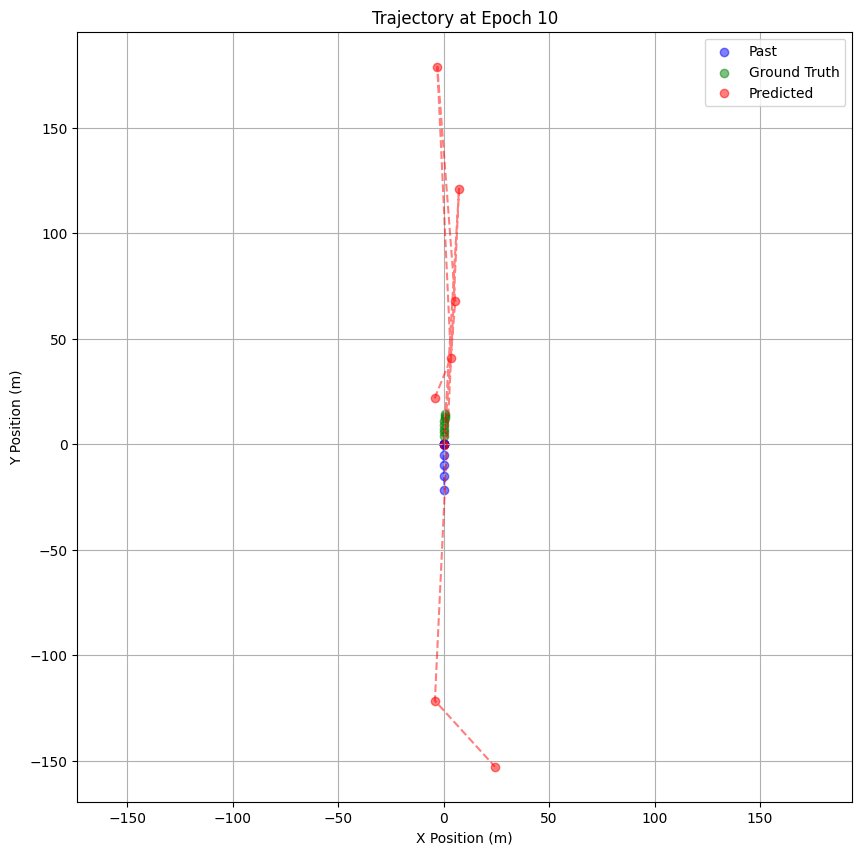

Epoch 11: 100%|██████████| 459/459 [00:02<00:00, 153.45it/s, loss=0.5588]



Epoch 11/100, Loss: 0.5769


Epoch 12: 100%|██████████| 459/459 [00:02<00:00, 154.41it/s, loss=0.5470]



Epoch 12/100, Loss: 0.5093


Epoch 13: 100%|██████████| 459/459 [00:02<00:00, 155.87it/s, loss=0.4687]



Epoch 13/100, Loss: 0.4582


Epoch 14: 100%|██████████| 459/459 [00:03<00:00, 145.51it/s, loss=0.3629]



Epoch 14/100, Loss: 0.4185


Epoch 15: 100%|██████████| 459/459 [00:02<00:00, 158.95it/s, loss=0.4152]



Epoch 15/100, Loss: 0.3852


Epoch 16: 100%|██████████| 459/459 [00:02<00:00, 157.52it/s, loss=0.3105]



Epoch 16/100, Loss: 0.3601


Epoch 17: 100%|██████████| 459/459 [00:02<00:00, 156.43it/s, loss=0.3288]



Epoch 17/100, Loss: 0.3216


Epoch 18: 100%|██████████| 459/459 [00:02<00:00, 155.27it/s, loss=0.2643]



Epoch 18/100, Loss: 0.2933


Epoch 19: 100%|██████████| 459/459 [00:03<00:00, 151.61it/s, loss=0.2360]



Epoch 19/100, Loss: 0.2720


Epoch 20: 100%|██████████| 459/459 [00:02<00:00, 156.17it/s, loss=0.2396]



Epoch 20/100, Loss: 0.2494


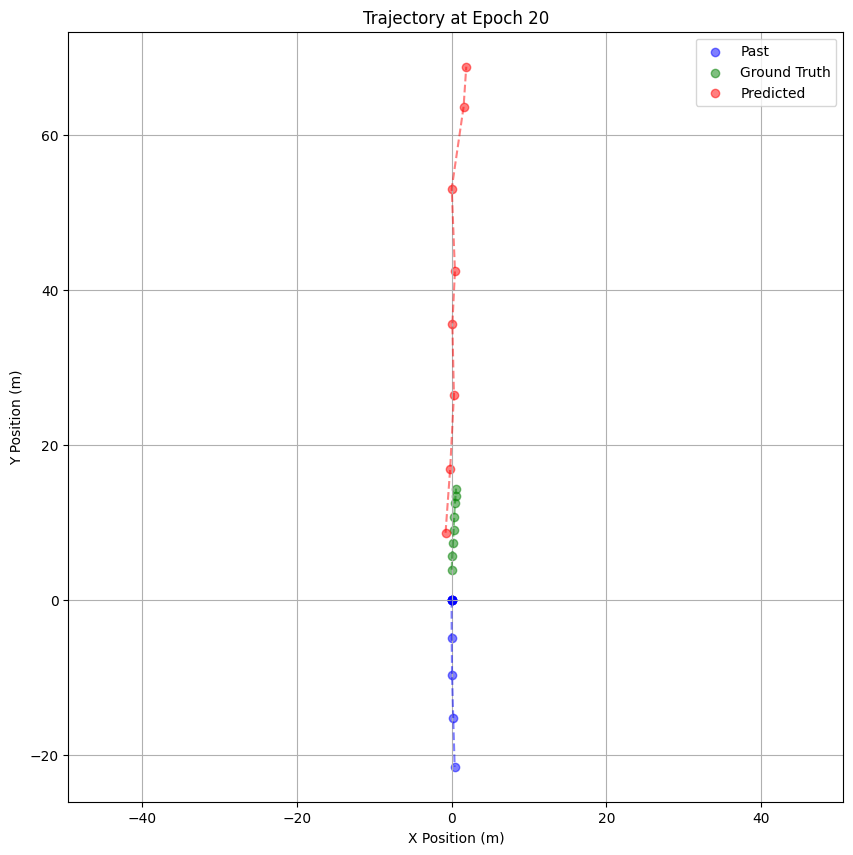

Epoch 21: 100%|██████████| 459/459 [00:02<00:00, 154.17it/s, loss=0.1950]



Epoch 21/100, Loss: 0.2267


Epoch 22: 100%|██████████| 459/459 [00:02<00:00, 154.90it/s, loss=0.1852]



Epoch 22/100, Loss: 0.2171


Epoch 23: 100%|██████████| 459/459 [00:02<00:00, 153.29it/s, loss=0.1951]



Epoch 23/100, Loss: 0.2009


Epoch 24: 100%|██████████| 459/459 [00:02<00:00, 159.73it/s, loss=0.1463]



Epoch 24/100, Loss: 0.1911


Epoch 25: 100%|██████████| 459/459 [00:02<00:00, 160.61it/s, loss=0.1338]



Epoch 25/100, Loss: 0.1950


Epoch 26: 100%|██████████| 459/459 [00:02<00:00, 157.74it/s, loss=0.2529]



Epoch 26/100, Loss: 0.1887


Epoch 27: 100%|██████████| 459/459 [00:02<00:00, 153.05it/s, loss=0.2096]



Epoch 27/100, Loss: 0.1776


Epoch 28: 100%|██████████| 459/459 [00:02<00:00, 158.27it/s, loss=0.2055]



Epoch 28/100, Loss: 0.1733


Epoch 29: 100%|██████████| 459/459 [00:02<00:00, 157.22it/s, loss=0.0724]



Epoch 29/100, Loss: 0.1616


Epoch 30: 100%|██████████| 459/459 [00:03<00:00, 144.68it/s, loss=0.1213]



Epoch 30/100, Loss: 0.1599


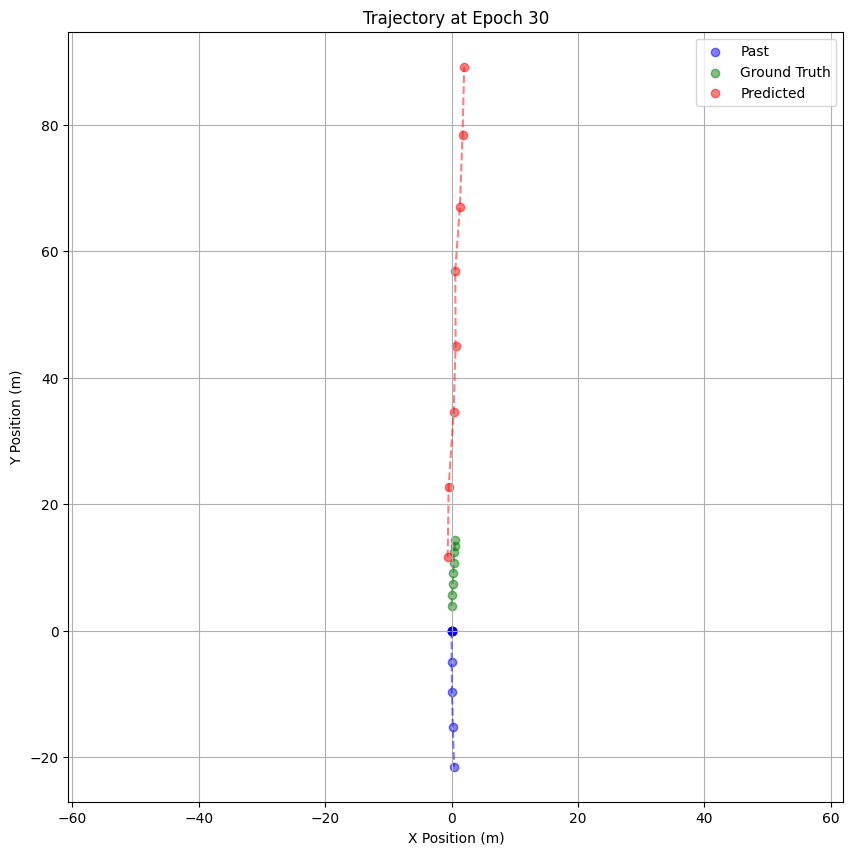

Epoch 31: 100%|██████████| 459/459 [00:03<00:00, 149.36it/s, loss=0.1818]



Epoch 31/100, Loss: 0.1515


Epoch 32: 100%|██████████| 459/459 [00:02<00:00, 153.79it/s, loss=0.1218]



Epoch 32/100, Loss: 0.1499


Epoch 33: 100%|██████████| 459/459 [00:02<00:00, 155.89it/s, loss=0.2201]



Epoch 33/100, Loss: 0.1448


Epoch 34: 100%|██████████| 459/459 [00:03<00:00, 145.02it/s, loss=0.1213]



Epoch 34/100, Loss: 0.1431


Epoch 35: 100%|██████████| 459/459 [00:03<00:00, 151.98it/s, loss=0.1278]



Epoch 35/100, Loss: 0.1391


Epoch 36: 100%|██████████| 459/459 [00:03<00:00, 150.73it/s, loss=0.1937]



Epoch 36/100, Loss: 0.1368


Epoch 37: 100%|██████████| 459/459 [00:02<00:00, 154.58it/s, loss=0.0995]



Epoch 37/100, Loss: 0.1323


Epoch 38: 100%|██████████| 459/459 [00:02<00:00, 156.43it/s, loss=0.2064]



Epoch 38/100, Loss: 0.1315


Epoch 39: 100%|██████████| 459/459 [00:02<00:00, 153.57it/s, loss=0.2507]



Epoch 39/100, Loss: 0.1274


Epoch 40: 100%|██████████| 459/459 [00:03<00:00, 148.90it/s, loss=0.1571]



Epoch 40/100, Loss: 0.1319


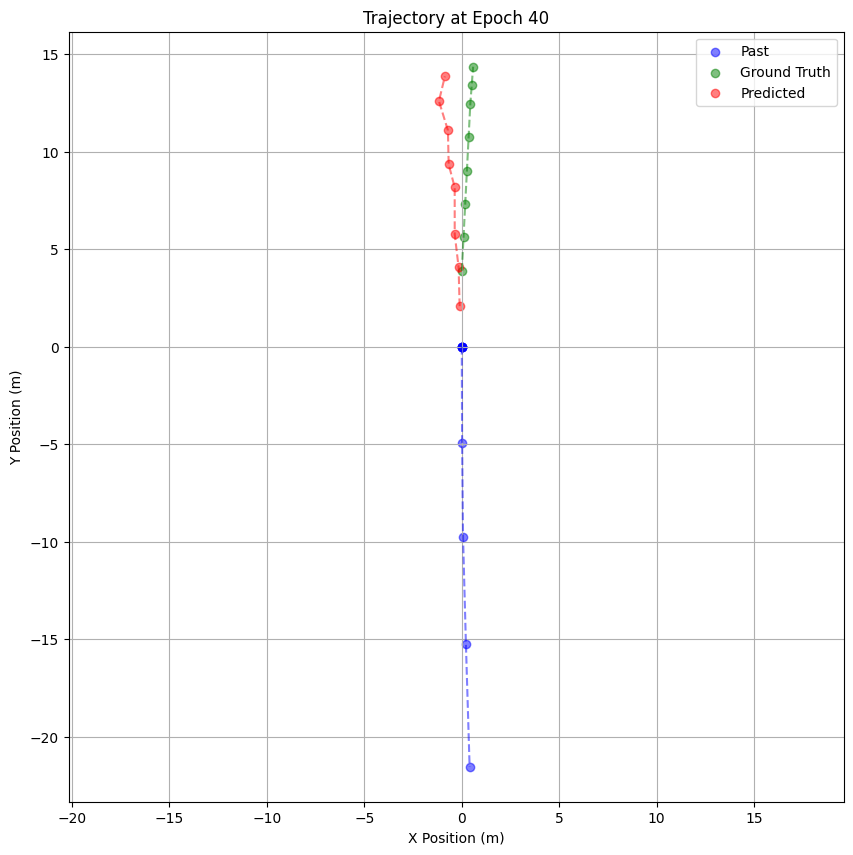

Epoch 41: 100%|██████████| 459/459 [00:03<00:00, 152.08it/s, loss=0.1309]



Epoch 41/100, Loss: 0.1289


Epoch 42: 100%|██████████| 459/459 [00:02<00:00, 156.85it/s, loss=0.0882]



Epoch 42/100, Loss: 0.1247


Epoch 43: 100%|██████████| 459/459 [00:02<00:00, 153.83it/s, loss=0.2208]



Epoch 43/100, Loss: 0.1255


Epoch 44: 100%|██████████| 459/459 [00:03<00:00, 151.39it/s, loss=0.1199]



Epoch 44/100, Loss: 0.1255


Epoch 45: 100%|██████████| 459/459 [00:03<00:00, 152.90it/s, loss=0.1022]



Epoch 45/100, Loss: 0.1241


Epoch 46: 100%|██████████| 459/459 [00:02<00:00, 154.54it/s, loss=0.0444]



Epoch 46/100, Loss: 0.1218


Epoch 47: 100%|██████████| 459/459 [00:02<00:00, 154.10it/s, loss=0.1441]



Epoch 47/100, Loss: 0.1202


Epoch 48: 100%|██████████| 459/459 [00:02<00:00, 154.01it/s, loss=0.1666]



Epoch 48/100, Loss: 0.1230


Epoch 49: 100%|██████████| 459/459 [00:03<00:00, 151.41it/s, loss=0.1586]



Epoch 49/100, Loss: 0.1218


Epoch 50: 100%|██████████| 459/459 [00:02<00:00, 155.91it/s, loss=0.1315]



Epoch 50/100, Loss: 0.1186


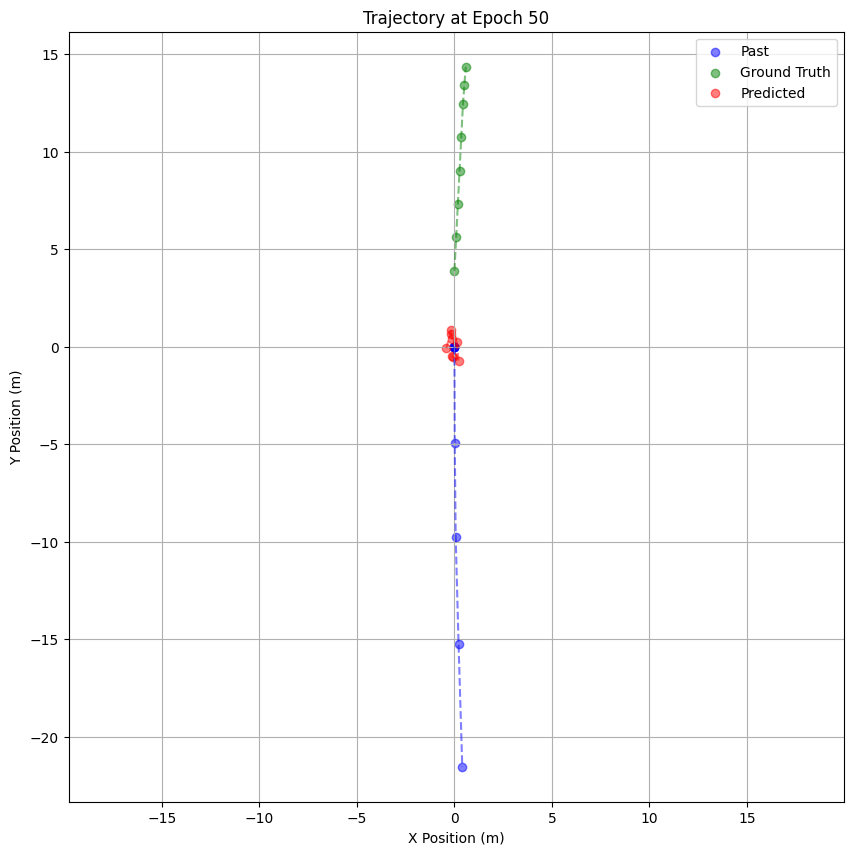

Epoch 51: 100%|██████████| 459/459 [00:03<00:00, 151.84it/s, loss=0.1282]



Epoch 51/100, Loss: 0.1191


Epoch 52: 100%|██████████| 459/459 [00:03<00:00, 152.30it/s, loss=0.1147]



Epoch 52/100, Loss: 0.1193


Epoch 53: 100%|██████████| 459/459 [00:03<00:00, 149.92it/s, loss=0.0964]



Epoch 53/100, Loss: 0.1178


Epoch 54: 100%|██████████| 459/459 [00:03<00:00, 152.57it/s, loss=0.0468]



Epoch 54/100, Loss: 0.1183


Epoch 55: 100%|██████████| 459/459 [00:02<00:00, 155.61it/s, loss=0.1157]



Epoch 55/100, Loss: 0.1166


Epoch 56: 100%|██████████| 459/459 [00:02<00:00, 156.92it/s, loss=0.1218]



Epoch 56/100, Loss: 0.1141


Epoch 57: 100%|██████████| 459/459 [00:03<00:00, 149.66it/s, loss=0.1099]



Epoch 57/100, Loss: 0.1172


Epoch 58: 100%|██████████| 459/459 [00:02<00:00, 156.47it/s, loss=0.1307]



Epoch 58/100, Loss: 0.1124


Epoch 59: 100%|██████████| 459/459 [00:02<00:00, 157.38it/s, loss=0.1468]



Epoch 59/100, Loss: 0.1124


Epoch 60: 100%|██████████| 459/459 [00:02<00:00, 157.52it/s, loss=0.0603]



Epoch 60/100, Loss: 0.1100


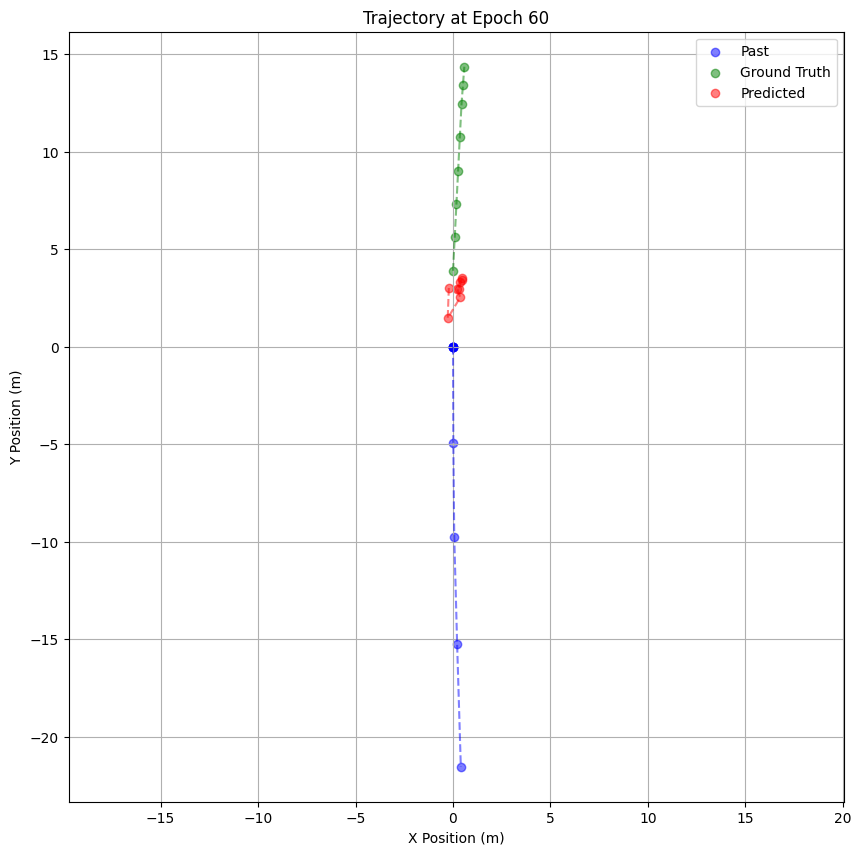

Epoch 61: 100%|██████████| 459/459 [00:03<00:00, 149.30it/s, loss=0.1122]



Epoch 61/100, Loss: 0.1131


Epoch 62: 100%|██████████| 459/459 [00:02<00:00, 155.32it/s, loss=0.1209]



Epoch 62/100, Loss: 0.1115


Epoch 63: 100%|██████████| 459/459 [00:02<00:00, 154.23it/s, loss=0.0693]



Epoch 63/100, Loss: 0.1110


Epoch 64: 100%|██████████| 459/459 [00:02<00:00, 156.15it/s, loss=0.0777]



Epoch 64/100, Loss: 0.1087


Epoch 65: 100%|██████████| 459/459 [00:02<00:00, 154.97it/s, loss=0.0847]



Epoch 65/100, Loss: 0.1107


Epoch 66: 100%|██████████| 459/459 [00:03<00:00, 149.71it/s, loss=0.1203]



Epoch 66/100, Loss: 0.1079


Epoch 67: 100%|██████████| 459/459 [00:02<00:00, 156.09it/s, loss=0.1258]



Epoch 67/100, Loss: 0.1086


Epoch 68: 100%|██████████| 459/459 [00:02<00:00, 155.80it/s, loss=0.1180]



Epoch 68/100, Loss: 0.1056


Epoch 69: 100%|██████████| 459/459 [00:02<00:00, 156.28it/s, loss=0.1054]



Epoch 69/100, Loss: 0.1077


Epoch 70: 100%|██████████| 459/459 [00:03<00:00, 149.84it/s, loss=0.1664]



Epoch 70/100, Loss: 0.1083


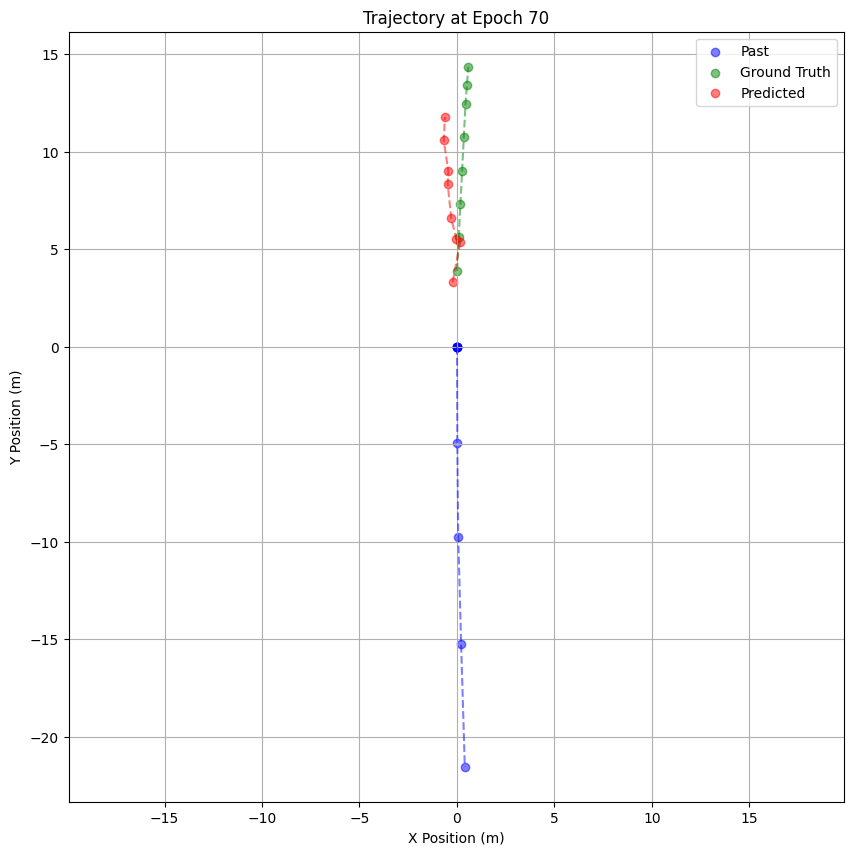

Epoch 71: 100%|██████████| 459/459 [00:02<00:00, 157.56it/s, loss=0.1199]



Epoch 71/100, Loss: 0.1095


Epoch 72: 100%|██████████| 459/459 [00:02<00:00, 154.87it/s, loss=0.1735]



Epoch 72/100, Loss: 0.1076


Epoch 73: 100%|██████████| 459/459 [00:02<00:00, 156.70it/s, loss=0.0698]



Epoch 73/100, Loss: 0.1097


Epoch 74: 100%|██████████| 459/459 [00:03<00:00, 147.24it/s, loss=0.1635]



Epoch 74/100, Loss: 0.1072


Epoch 75: 100%|██████████| 459/459 [00:02<00:00, 154.38it/s, loss=0.0737]



Epoch 75/100, Loss: 0.1070


Epoch 76: 100%|██████████| 459/459 [00:02<00:00, 155.79it/s, loss=0.1162]



Epoch 76/100, Loss: 0.1033


Epoch 77: 100%|██████████| 459/459 [00:02<00:00, 157.35it/s, loss=0.0981]



Epoch 77/100, Loss: 0.1061


Epoch 78: 100%|██████████| 459/459 [00:03<00:00, 152.81it/s, loss=0.1980]



Epoch 78/100, Loss: 0.1043


Epoch 79: 100%|██████████| 459/459 [00:03<00:00, 151.43it/s, loss=0.0971]



Epoch 79/100, Loss: 0.1044


Epoch 80: 100%|██████████| 459/459 [00:02<00:00, 153.96it/s, loss=0.0963]



Epoch 80/100, Loss: 0.1045


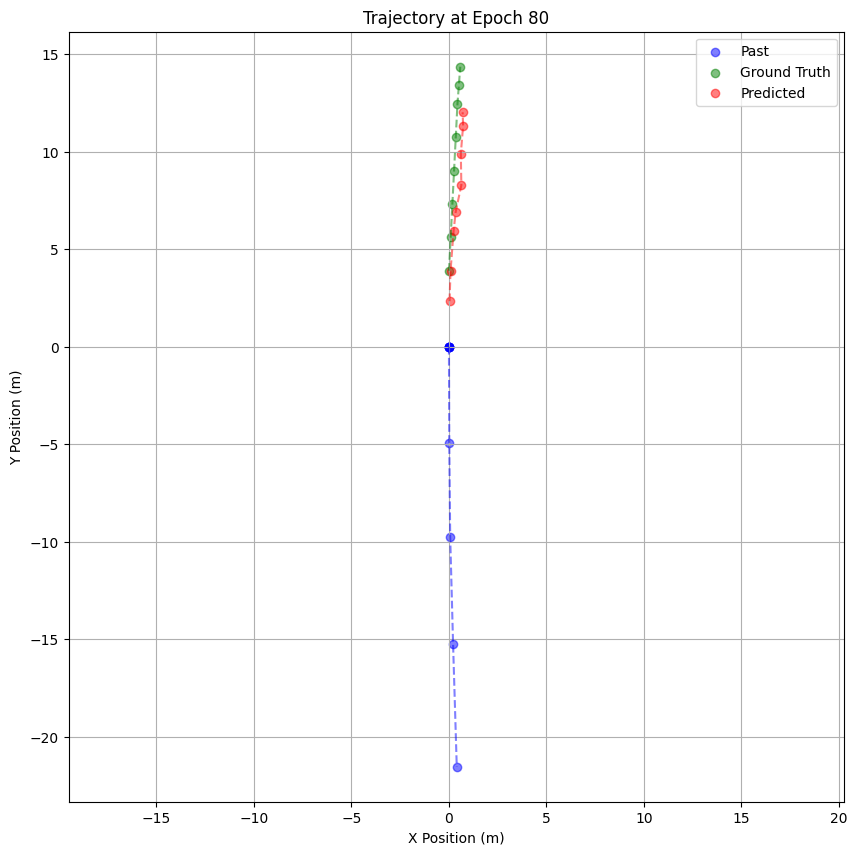

Epoch 81: 100%|██████████| 459/459 [00:02<00:00, 156.81it/s, loss=0.0984]



Epoch 81/100, Loss: 0.1059


Epoch 82: 100%|██████████| 459/459 [00:02<00:00, 154.83it/s, loss=0.0906]



Epoch 82/100, Loss: 0.1053


Epoch 83: 100%|██████████| 459/459 [00:03<00:00, 152.67it/s, loss=0.0804]



Epoch 83/100, Loss: 0.1019


Epoch 84: 100%|██████████| 459/459 [00:02<00:00, 157.14it/s, loss=0.1776]



Epoch 84/100, Loss: 0.1041


Epoch 85: 100%|██████████| 459/459 [00:02<00:00, 158.65it/s, loss=0.1335]



Epoch 85/100, Loss: 0.1019


Epoch 86: 100%|██████████| 459/459 [00:03<00:00, 152.13it/s, loss=0.1333]



Epoch 86/100, Loss: 0.0982


Epoch 87: 100%|██████████| 459/459 [00:03<00:00, 149.91it/s, loss=0.1138]



Epoch 87/100, Loss: 0.1026


Epoch 88: 100%|██████████| 459/459 [00:02<00:00, 157.32it/s, loss=0.1248]



Epoch 88/100, Loss: 0.1018


Epoch 89: 100%|██████████| 459/459 [00:02<00:00, 155.63it/s, loss=0.1406]



Epoch 89/100, Loss: 0.1006


Epoch 90: 100%|██████████| 459/459 [00:02<00:00, 157.34it/s, loss=0.1381]



Epoch 90/100, Loss: 0.1042


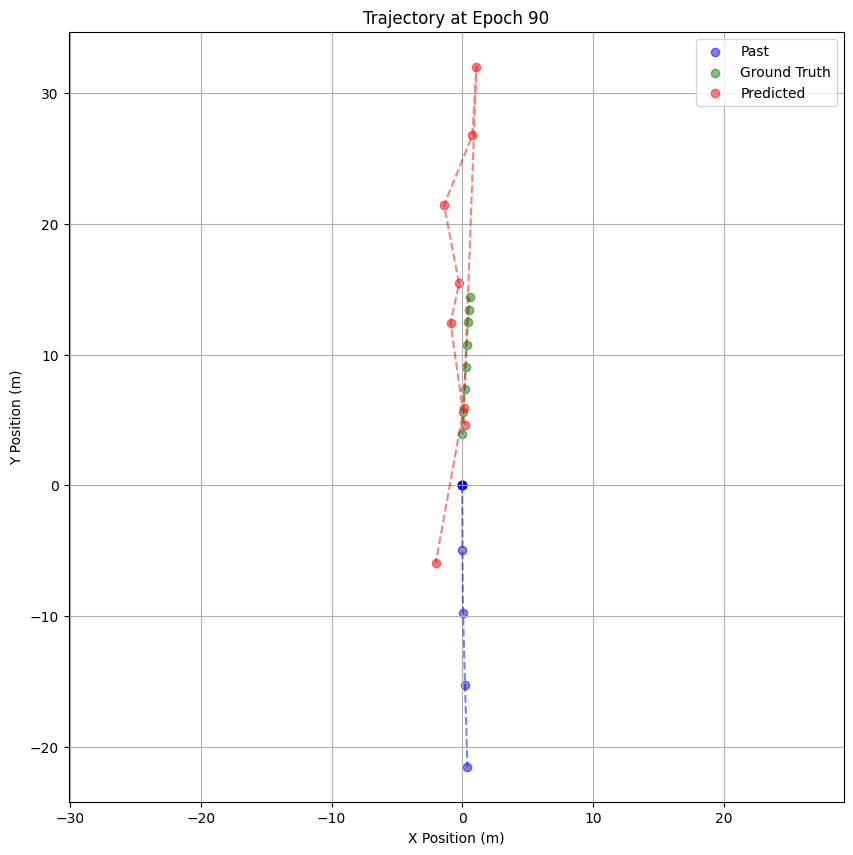

Epoch 91: 100%|██████████| 459/459 [00:03<00:00, 151.14it/s, loss=0.0727]



Epoch 91/100, Loss: 0.0994


Epoch 92: 100%|██████████| 459/459 [00:02<00:00, 156.05it/s, loss=0.1810]



Epoch 92/100, Loss: 0.1022


Epoch 93: 100%|██████████| 459/459 [00:02<00:00, 155.64it/s, loss=0.2106]



Epoch 93/100, Loss: 0.0992


Epoch 94: 100%|██████████| 459/459 [00:02<00:00, 153.08it/s, loss=0.1507]



Epoch 94/100, Loss: 0.1023


Epoch 95: 100%|██████████| 459/459 [00:02<00:00, 155.17it/s, loss=0.0785]



Epoch 95/100, Loss: 0.1012


Epoch 96: 100%|██████████| 459/459 [00:03<00:00, 149.93it/s, loss=0.0546]



Epoch 96/100, Loss: 0.0983


Epoch 97: 100%|██████████| 459/459 [00:02<00:00, 156.50it/s, loss=0.0782]



Epoch 97/100, Loss: 0.1009


Epoch 98: 100%|██████████| 459/459 [00:02<00:00, 157.35it/s, loss=0.1514]



Epoch 98/100, Loss: 0.1014


Epoch 99: 100%|██████████| 459/459 [00:02<00:00, 157.50it/s, loss=0.0484]



Epoch 99/100, Loss: 0.1019


Epoch 100: 100%|██████████| 459/459 [00:03<00:00, 148.62it/s, loss=0.0592]



Epoch 100/100, Loss: 0.1010


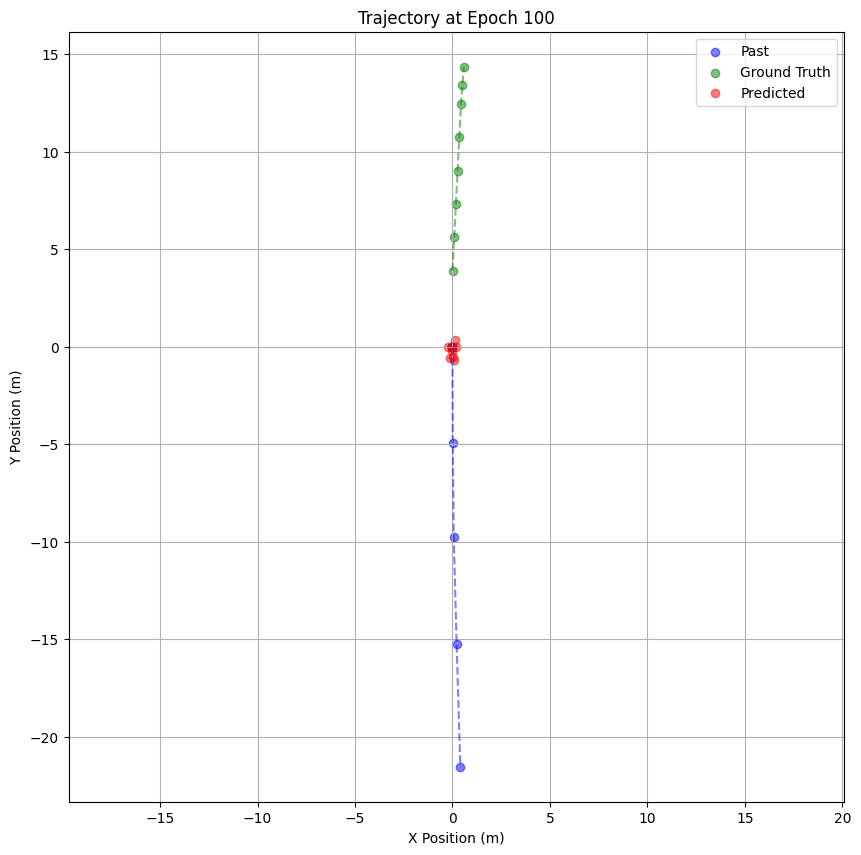

In [11]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from typing import Dict, List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import numpy as np
from torch.utils.data import Dataset
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from typing import Dict, List, Tuple

class VehicleTrajectoryDataset(Dataset):
    def __init__(self,
                 nusc: NuScenes,
                 helper: PredictHelper,
                 history_seconds: float = 2.0,
                 future_seconds: float = 4.0,
                 history_freq: float = 5.0,  # 5Hz
                 future_freq: float = 2.0,   # 2Hz
                 min_movement: float = 1.0,  # meters
                 max_vehicle_speed: float = 30.0):  # m/s (~108 km/h)

        self.nusc = nusc
        self.helper = helper
        self.history_seconds = history_seconds
        self.future_seconds = future_seconds
        self.history_freq = history_freq
        self.future_freq = future_freq
        self.min_movement = min_movement
        self.max_vehicle_speed = max_vehicle_speed

        self.car_category = 'vehicle.car'

        # Calculate number of steps
        self.history_steps = int(history_seconds * history_freq)
        self.future_steps = int(future_seconds * future_freq)

        # Vehicle categories in nuScenes
        self.vehicle_categories = [
            'vehicle.car',
            'vehicle.truck',
            'vehicle.bus',
            'vehicle.trailer'
        ]

        # Collect valid vehicle trajectories
        self.valid_samples = self._collect_valid_samples()
        print(f"Found {len(self.valid_samples)} valid vehicle trajectories")

    def _collect_valid_samples(self) -> List[Dict]:
        valid_samples = []
        total_samples = 0
        filtered_counts = {
            'non_vehicle': 0,
            'insufficient_history': 0,
            'insufficient_future': 0,
            'static': 0,
            'invalid_velocity': 0
        }

        for scene in self.nusc.scene:
            sample_token = scene['first_sample_token']

            while sample_token:
                sample = self.nusc.get('sample', sample_token)

                for ann_token in sample['anns']:
                    total_samples += 1
                    ann = self.nusc.get('sample_annotation', ann_token)

                    # Check if it's a vehicle
                    if not any(ann['category_name'].startswith(cat) for cat in self.car_category):
                        filtered_counts['non_car'] += 1
                        continue

                    try:
                        # Get trajectories
                        past = self.helper.get_past_for_agent(
                            ann['instance_token'],
                            sample_token,
                            seconds=self.history_seconds,
                            in_agent_frame=True
                        )

                        future = self.helper.get_future_for_agent(
                            ann['instance_token'],
                            sample_token,
                            seconds=self.future_seconds,
                            in_agent_frame=True
                        )

                        # Apply filtering criteria
                        if len(past) < self.history_steps * 0.5:
                            filtered_counts['insufficient_history'] += 1
                            continue

                        if len(future) < self.future_steps * 0.5:
                            filtered_counts['insufficient_future'] += 1
                            continue

                        # Check if vehicle is moving
                        total_movement = np.linalg.norm(future[-1] - past[0])
                        if total_movement < self.min_movement:
                            filtered_counts['static'] += 1
                            continue

                        # Check for valid velocities
                        max_step_dist = self.max_vehicle_speed * (1.0/self.history_freq)

                        valid_velocity = True
                        for i in range(1, len(past)):
                            if np.linalg.norm(past[i] - past[i-1]) > max_step_dist:
                                valid_velocity = False
                                break

                        for i in range(1, len(future)):
                            if np.linalg.norm(future[i] - future[i-1]) > max_step_dist:
                                valid_velocity = False
                                break

                        if not valid_velocity:
                            filtered_counts['invalid_velocity'] += 1
                            continue

                        # If all checks pass, add to valid samples
                        valid_samples.append({
                            'sample_token': sample_token,
                            'instance_token': ann['instance_token'],
                            'category': ann['category_name']
                        })

                    except Exception as e:
                        print(f"Error processing sample {sample_token}: {e}")
                        continue

                sample_token = sample['next']

        # Print filtering statistics
        print("\nTrajectory Filtering Statistics:")
        print(f"Total samples processed: {total_samples}")
        for reason, count in filtered_counts.items():
            print(f"Filtered {reason}: {count} ({count/total_samples*100:.1f}%)")
        print(f"Valid samples: {len(valid_samples)} ({len(valid_samples)/total_samples*100:.1f}%)")

        return valid_samples

    def __len__(self) -> int:
        return len(self.valid_samples)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        sample = self.valid_samples[idx]

        # Get trajectories
        past = self.helper.get_past_for_agent(
            sample['instance_token'],
            sample['sample_token'],
            seconds=self.history_seconds,
            in_agent_frame=True
        )

        future = self.helper.get_future_for_agent(
            sample['instance_token'],
            sample['sample_token'],
            seconds=self.future_seconds,
            in_agent_frame=True
        )

        # Convert to tensors with fixed size
        past_tensor = torch.zeros(self.history_steps, 2)
        if len(past) > 0:
            past_tensor[-len(past):] = torch.tensor(past)

        future_tensor = torch.zeros(self.future_steps, 2)
        if len(future) > 0:
            future_tensor[:len(future)] = torch.tensor(future)

        return {
            'past': past_tensor,
            'future': future_tensor,
            'category': sample['category']
        }

class DiffusionModel(nn.Module):
    def __init__(self,
                 history_steps: int,
                 future_steps: int,
                 hidden_size: int = 256,
                 num_diffusion_steps: int = 1000):
        super().__init__()
        self.history_steps = history_steps
        self.future_steps = future_steps
        self.num_diffusion_steps = num_diffusion_steps

        # Encoder for past trajectory
        self.history_encoder = nn.Sequential(
            nn.Linear(history_steps * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size + hidden_size + future_steps * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, future_steps * 2)
        )

        # Setup noise schedule
        betas = torch.linspace(1e-4, 0.02, num_diffusion_steps)
        alphas = 1 - betas
        self.register_buffer('alphas_cumprod', torch.cumprod(alphas, dim=0))

    def forward(self, history: torch.Tensor, noisy_future: torch.Tensor,
                timesteps: torch.Tensor) -> torch.Tensor:
        # Encode history
        history_feat = self.history_encoder(history.reshape(history.shape[0], -1))

        # Embed timesteps
        time_feat = self.time_embed(timesteps.unsqueeze(-1).float())

        # Combine features
        combined = torch.cat([
            history_feat,
            time_feat,
            noisy_future.reshape(noisy_future.shape[0], -1)
        ], dim=-1)

        # Predict noise
        pred_noise = self.decoder(combined)
        return pred_noise.reshape(noisy_future.shape)

def visualize_trajectories(past: torch.Tensor,
                         future: torch.Tensor,
                         predicted: torch.Tensor,
                         title: str = "Trajectory Visualization"):
    """Visualize actual and predicted trajectories."""
    plt.figure(figsize=(10, 10))

    # Plot past trajectory
    plt.scatter(past[:, 0], past[:, 1], c='blue', label='Past', alpha=0.5)
    plt.plot(past[:, 0], past[:, 1], 'b--', alpha=0.5)

    # Plot ground truth future
    plt.scatter(future[:, 0], future[:, 1], c='green', label='Ground Truth', alpha=0.5)
    plt.plot(future[:, 0], future[:, 1], 'g--', alpha=0.5)

    # Plot predicted trajectories
    plt.scatter(predicted[:, 0], predicted[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.plot(predicted[:, 0], predicted[:, 1], 'r--', alpha=0.5)

    plt.title(title)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

def sample_trajectories(model: nn.Module,
                       past: torch.Tensor,
                       num_steps: int = 1000,
                       device: torch.device = None) -> torch.Tensor:
    """Sample trajectories using the diffusion model."""
    model.eval()
    batch_size = past.shape[0]

    # Start from random noise
    x = torch.randn(batch_size, model.future_steps, 2, device=device)

    # Gradually denoise
    for t in tqdm(reversed(range(num_steps)), desc="Sampling", leave=False):
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)

        # Predict noise
        with torch.no_grad():
            predicted_noise = model(past, x, t_batch)

        # Update sample
        alpha = model.alphas_cumprod[t]
        alpha_prev = model.alphas_cumprod[t-1] if t > 0 else torch.tensor(1.0)
        beta = 1 - alpha/alpha_prev

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / torch.sqrt(1 - beta)) * (x - beta / torch.sqrt(1 - alpha) * predicted_noise) + \
            torch.sqrt(beta) * noise

    return x

def train_epoch(model: nn.Module,
                dataloader: DataLoader,
                optimizer: torch.optim.Optimizer,
                device: torch.device,
                epoch: int) -> float:
    model.train()
    total_loss = 0

    # Create progress bar
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=True)

    for batch in pbar:
        # Get data
        past = batch['past'].to(device)
        future = batch['future'].to(device)

        # Sample random timesteps
        t = torch.randint(0, model.num_diffusion_steps, (past.shape[0],), device=device)

        # Add noise to future trajectory
        noise = torch.randn_like(future)
        alphas_cumprod_t = model.alphas_cumprod[t]
        noisy_future = torch.sqrt(alphas_cumprod_t.unsqueeze(-1).unsqueeze(-1)) * future + \
                      torch.sqrt(1 - alphas_cumprod_t.unsqueeze(-1).unsqueeze(-1)) * noise

        # Predict noise
        pred_noise = model(past, noisy_future, t)

        # Calculate loss
        loss = torch.nn.functional.mse_loss(pred_noise, noise)

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(dataloader)

def main():
    # Initialize NuScenes
    dataroot = "/content/drive/MyDrive/v1.0-mini 2" # Adjust this to your actual path
    nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)
    helper = PredictHelper(nusc)

    # Create dataset and dataloader
    dataset = TrajectoryDataset(nusc, helper)
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        num_workers=4
    )

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = DiffusionModel(
        history_steps=int(2.0 * 5),  # 2 seconds at 2Hz
        future_steps=int(4.0 * 2)    # 6 seconds at 2Hz
    ).to(device)

    # Setup optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training loop
    num_epochs = 100
    best_loss = float('inf')

    # Get one batch for visualization
    vis_batch = next(iter(dataloader))
    vis_past = vis_batch['past'][:1].to(device)  # Take first trajectory
    vis_future = vis_batch['future'][:1].to(device)

    for epoch in range(num_epochs):
        # Train one epoch
        loss = train_epoch(model, dataloader, optimizer, device, epoch)
        print(f"\nEpoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

        # Generate and visualize sample trajectory every 10 epochs
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                predicted = sample_trajectories(
                    model,
                    vis_past,
                    num_steps=model.num_diffusion_steps,
                    device=device
                )

                # Visualize
                visualize_trajectories(
                    vis_past[0].cpu().numpy(),
                    vis_future[0].cpu().numpy(),
                    predicted[0].cpu().numpy(),
                    f"Trajectory at Epoch {epoch+1}"
                )

        # Save best model
        if loss < best_loss:
            best_loss = loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, 'best_diffusion_model.pt')

if __name__ == "__main__":
    main()

Loading NuScenes tables for version v1.0-mini...


<ipython-input-12-f610f0461c9c>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.754 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Found 14688 valid trajectories


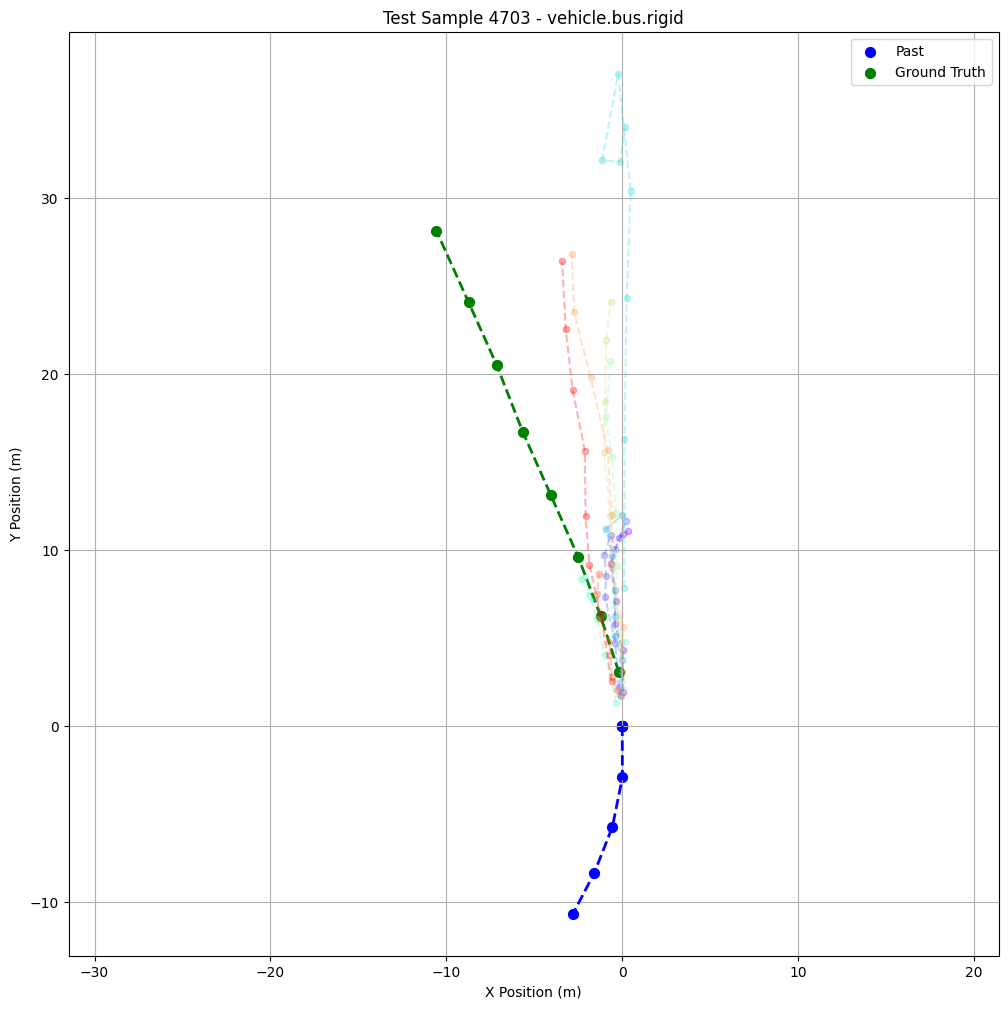


Test Sample 4703:
Category: vehicle.bus.rigid
Mean Final Displacement Error: 15.70m
Min Final Displacement Error: 7.35m
Max Final Displacement Error: 25.70m


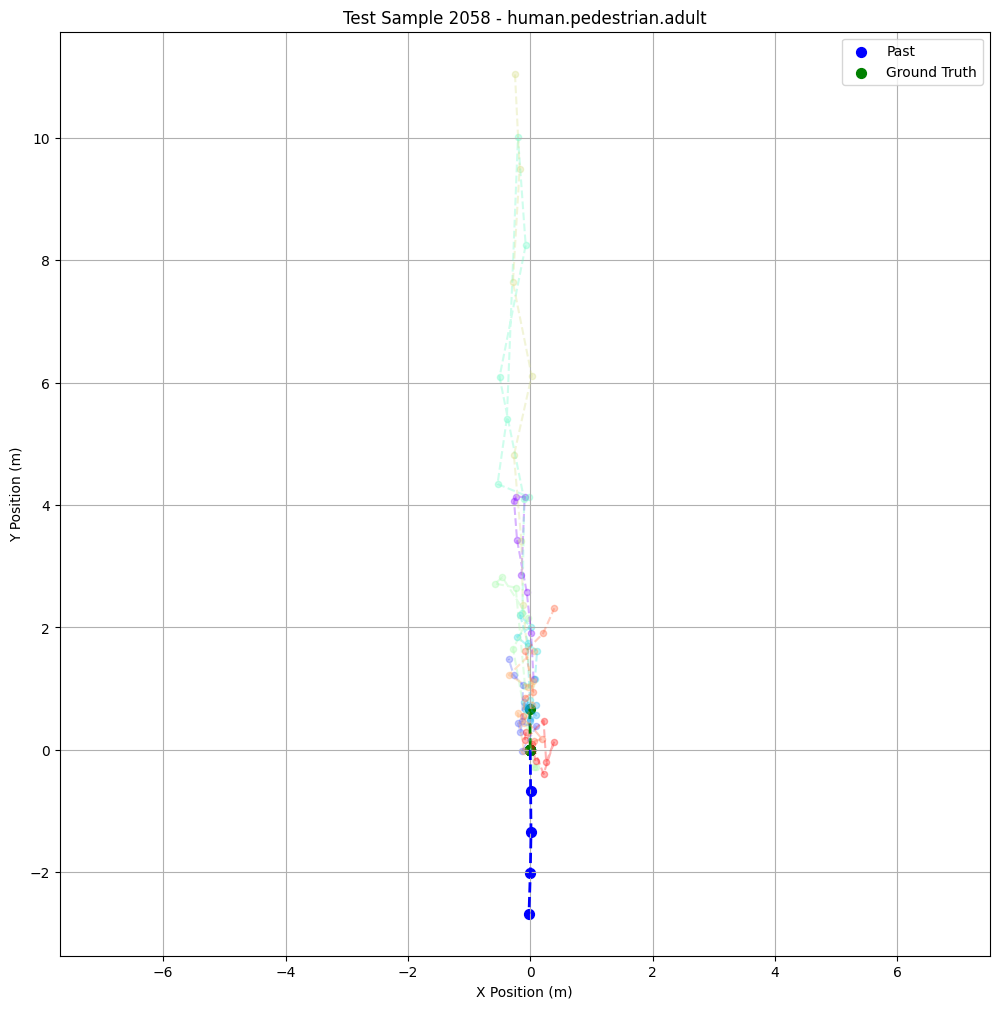


Test Sample 2058:
Category: human.pedestrian.adult
Mean Final Displacement Error: 2.59m
Min Final Displacement Error: 0.20m
Max Final Displacement Error: 11.05m


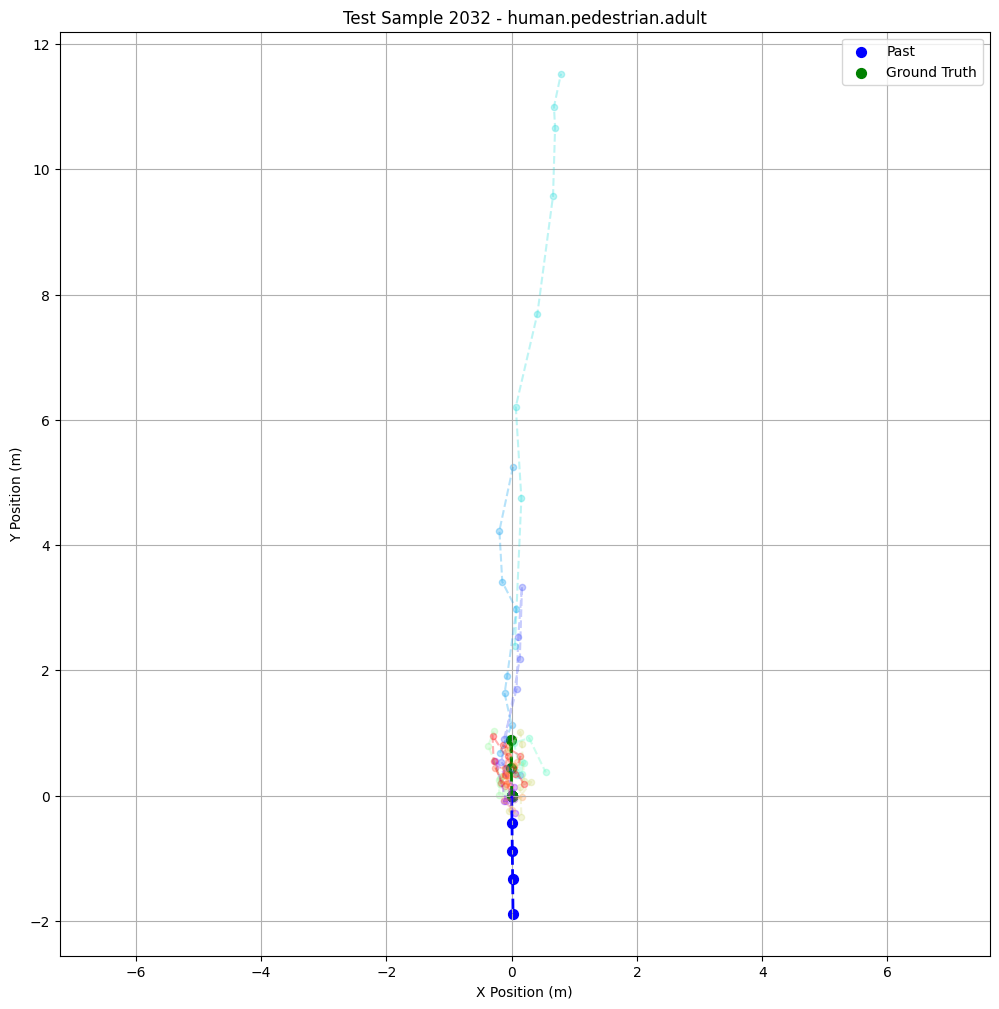


Test Sample 2032:
Category: human.pedestrian.adult
Mean Final Displacement Error: 2.00m
Min Final Displacement Error: 0.17m
Max Final Displacement Error: 11.55m


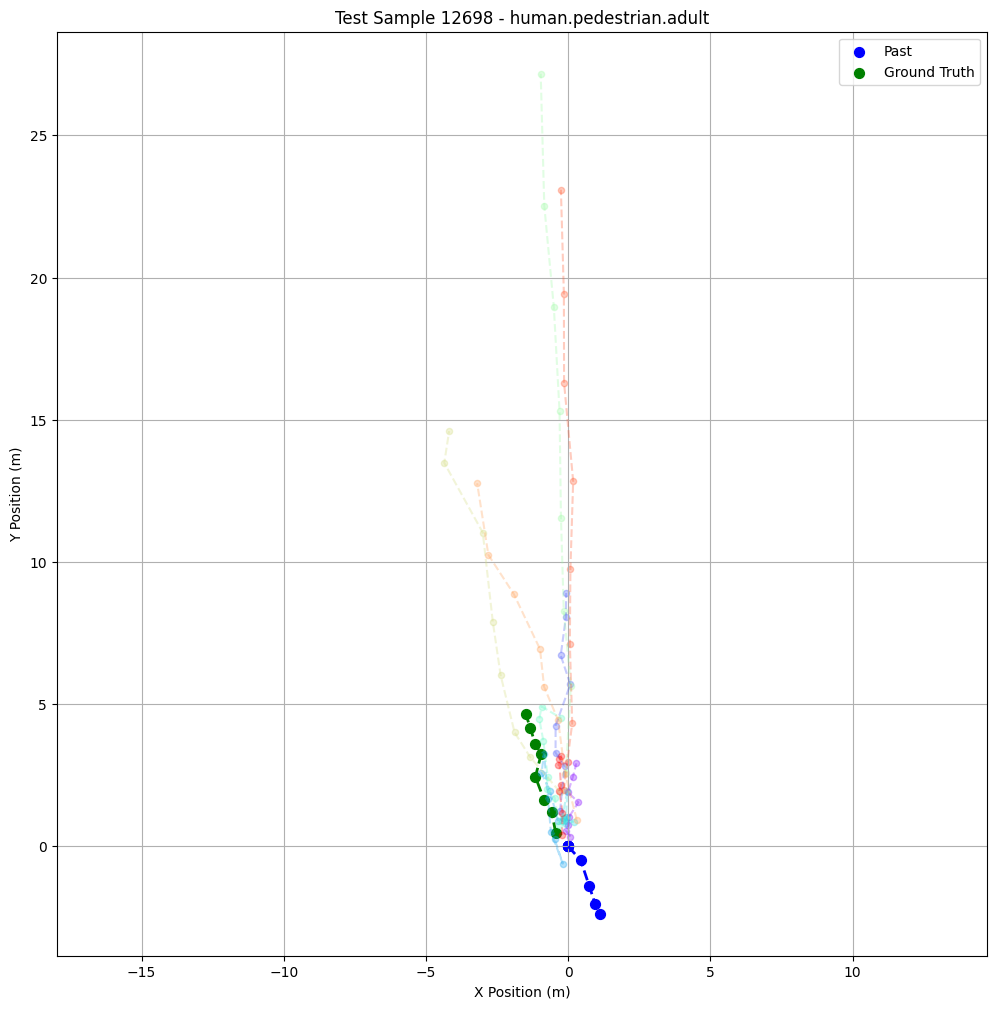


Test Sample 12698:
Category: human.pedestrian.adult
Mean Final Displacement Error: 7.84m
Min Final Displacement Error: 1.26m
Max Final Displacement Error: 22.51m


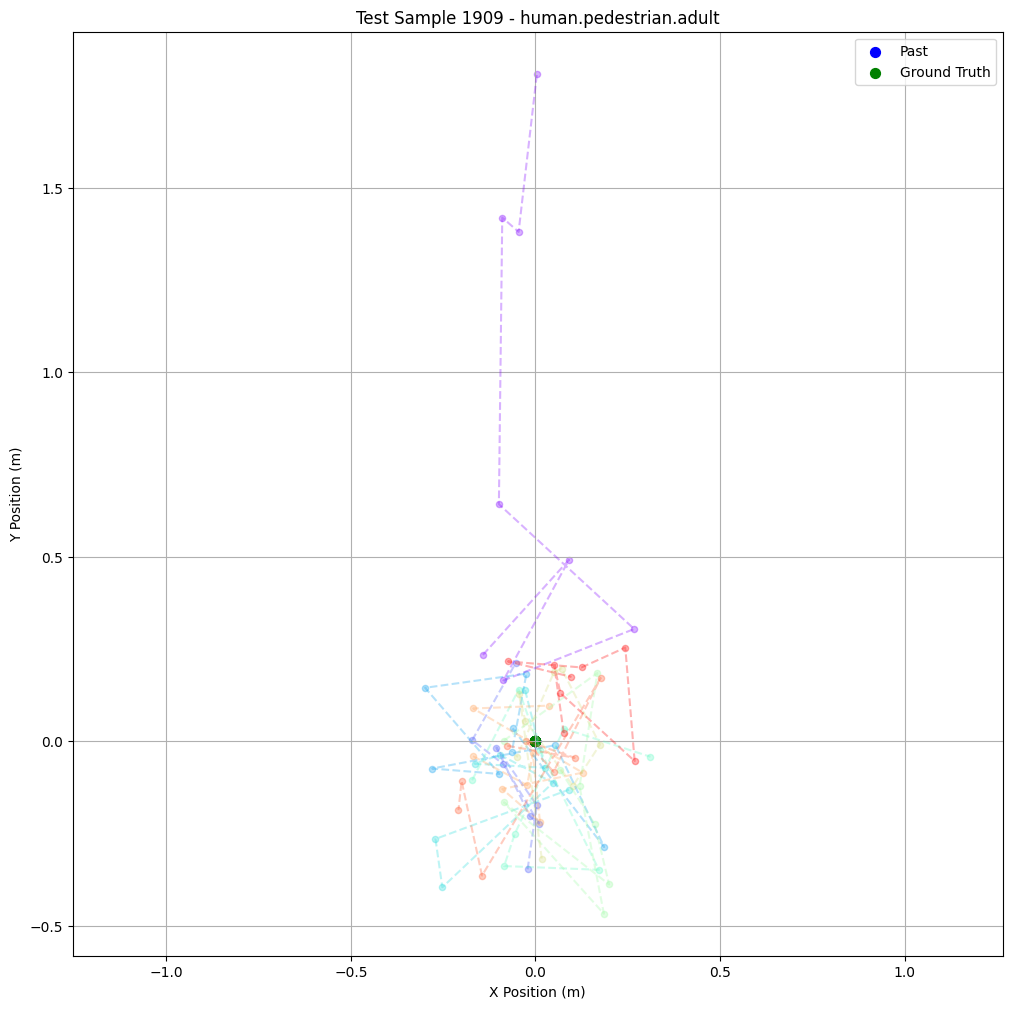


Test Sample 1909:
Category: human.pedestrian.adult
Mean Final Displacement Error: 0.33m
Min Final Displacement Error: 0.07m
Max Final Displacement Error: 1.81m


In [12]:
import torch
import matplotlib.pyplot as plt
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
import numpy as np
from typing import List

def load_trained_model(model_path: "/content/best_diffusion_model.pt", device: torch.device) -> DiffusionModel:
    """Load the trained model."""
    # Initialize model with same parameters as training
    model = DiffusionModel(
        history_steps=int(2.0 * 5),  # 2 seconds at 2Hz
        future_steps=int(4.0 * 2)    # 6 seconds at 2Hz
    ).to(device)

    # Load trained weights
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    return model

def generate_multiple_trajectories(model: DiffusionModel,
                                 past: torch.Tensor,
                                 num_samples: int = 15,
                                 device: torch.device = None) -> torch.Tensor:
    """Generate multiple trajectory predictions."""
    all_predictions = []

    for _ in range(num_samples):
        prediction = sample_trajectories(
            model,
            past,
            num_steps=model.num_diffusion_steps,
            device=device
        )
        all_predictions.append(prediction)

    return torch.cat(all_predictions, dim=0)

def visualize_multiple_trajectories(past: np.ndarray,
                                  future: np.ndarray,
                                  predictions: List[np.ndarray],
                                  title: str = "Multiple Trajectory Predictions"):
    """Visualize multiple predicted trajectories."""
    plt.figure(figsize=(12, 12))

    # Plot past trajectory
    plt.scatter(past[:, 0], past[:, 1], c='blue', label='Past', s=50)
    plt.plot(past[:, 0], past[:, 1], 'b--', linewidth=2)

    # Plot ground truth future
    plt.scatter(future[:, 0], future[:, 1], c='green', label='Ground Truth', s=50)
    plt.plot(future[:, 0], future[:, 1], 'g--', linewidth=2)

    # Plot predicted trajectories
    colors = plt.cm.rainbow(np.linspace(0, 1, len(predictions)))
    for pred, color in zip(predictions, colors):
        plt.scatter(pred[:, 0], pred[:, 1], c=[color], alpha=0.3, s=20)
        plt.plot(pred[:, 0], pred[:, 1], '--', c=color, alpha=0.3)

    plt.title(title)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# Test the model
def test_model():
    # Initialize NuScenes
    dataroot = "/content/drive/MyDrive/v1.0-mini 2" # Adjust this path
    nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)
    helper = PredictHelper(nusc)

    # Create test dataset
    dataset = TrajectoryDataset(nusc, helper)

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = load_trained_model('best_diffusion_model.pt', device)

    # Test on multiple trajectories
    num_test_samples = 5
    test_indices = np.random.choice(len(dataset), num_test_samples, replace=False)

    for idx in test_indices:
        data = dataset[idx]
        past = data['past'].unsqueeze(0).to(device)
        future = data['future']

        # Generate multiple predictions
        predictions = generate_multiple_trajectories(
            model,
            past,
            num_samples=10,
            device=device
        )

        # Visualize
        visualize_multiple_trajectories(
            past[0].cpu().numpy(),
            future.numpy(),
            [pred.cpu().numpy() for pred in predictions],
            f"Test Sample {idx} - {data['category']}"
        )

        # Print some statistics
        future_np = future.numpy()
        pred_np = predictions.cpu().numpy()

        # Calculate final displacement error for each prediction
        fde = np.linalg.norm(
            pred_np[:, -1, :] - future_np[-1:],
            axis=1
        )

        print(f"\nTest Sample {idx}:")
        print(f"Category: {data['category']}")
        print(f"Mean Final Displacement Error: {fde.mean():.2f}m")
        print(f"Min Final Displacement Error: {fde.min():.2f}m")
        print(f"Max Final Displacement Error: {fde.max():.2f}m")

if __name__ == "__main__":
    test_model()

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.748 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Found 14688 valid trajectories

Testing Statistics:
Total trajectories: 14688
Moving car trajectories: 1183
Using device: cuda


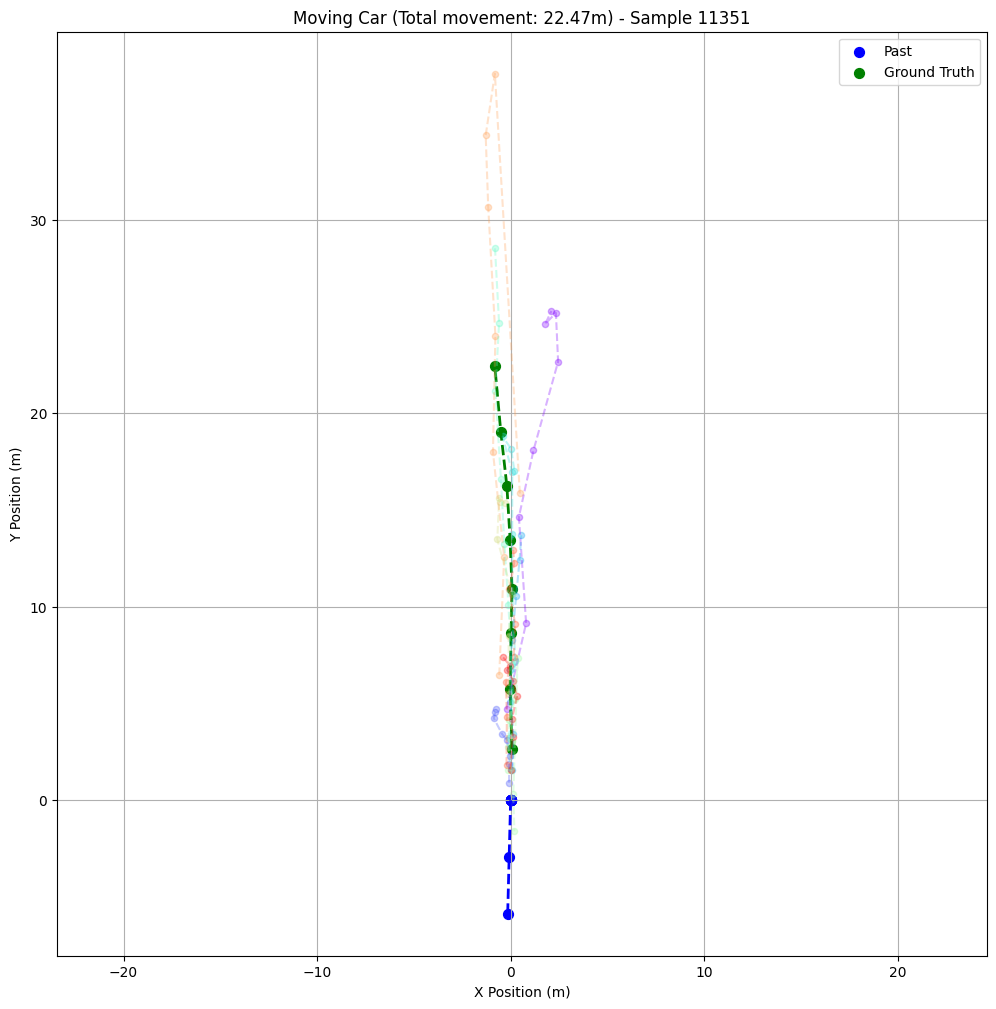


Test Sample 11351:
Total movement: 22.47m
Mean Final Displacement Error: 10.48m
Min Final Displacement Error: 4.07m
Max Final Displacement Error: 24.08m


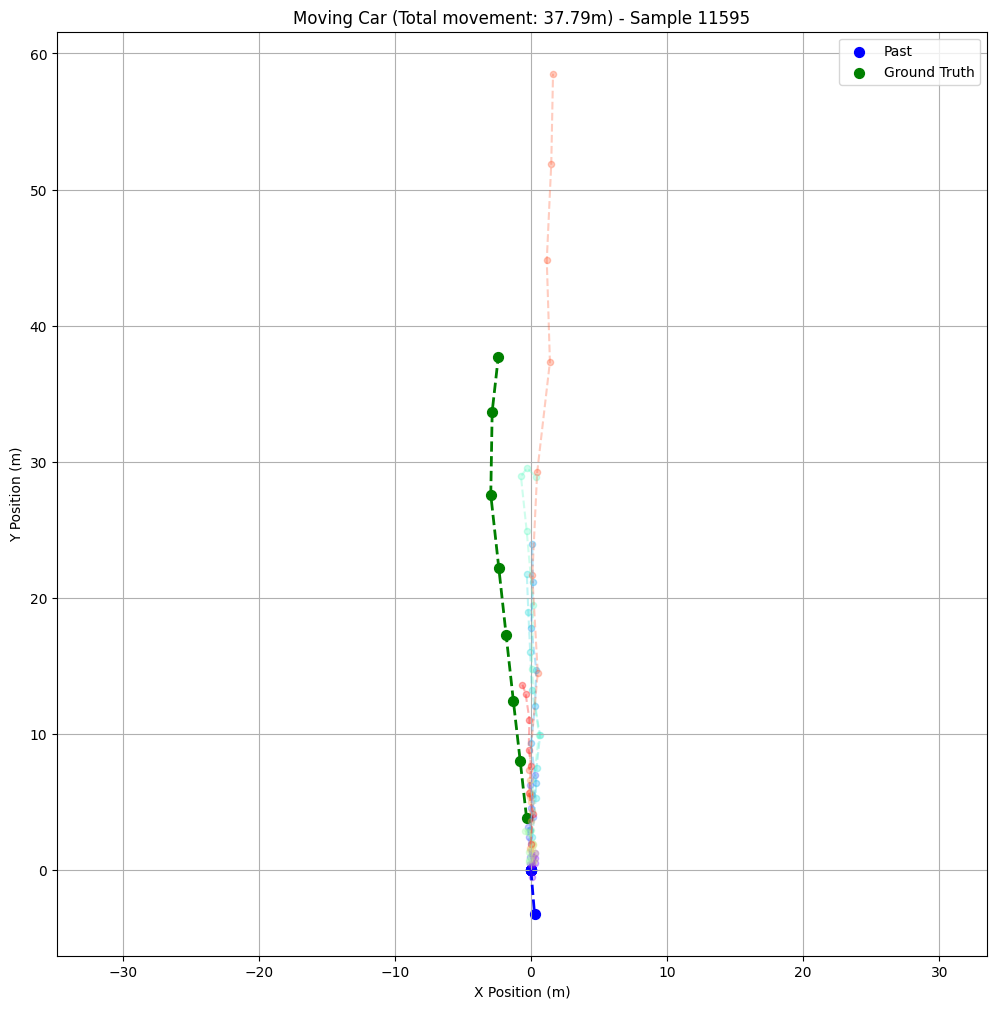


Test Sample 11595:
Total movement: 37.79m
Mean Final Displacement Error: 25.77m
Min Final Displacement Error: 9.24m
Max Final Displacement Error: 37.07m


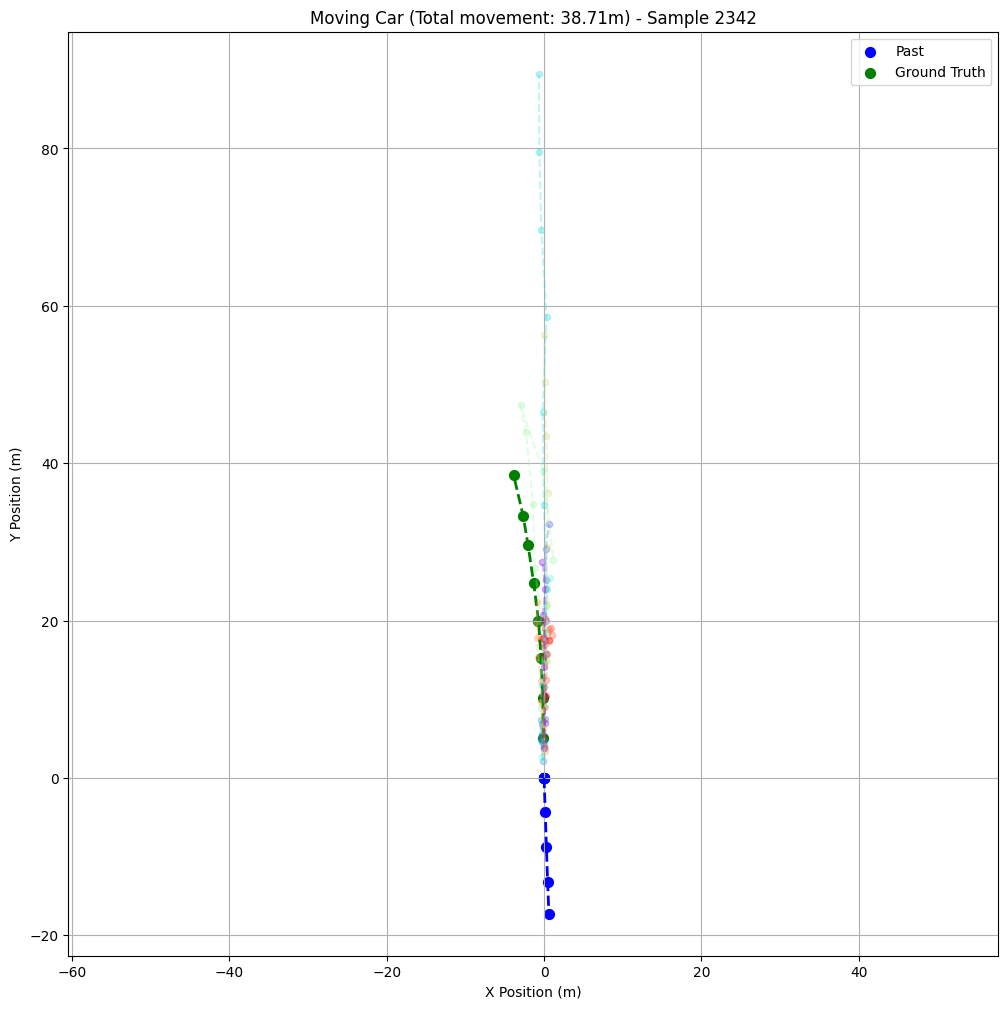


Test Sample 2342:
Total movement: 38.71m
Mean Final Displacement Error: 20.72m
Min Final Displacement Error: 7.73m
Max Final Displacement Error: 51.08m


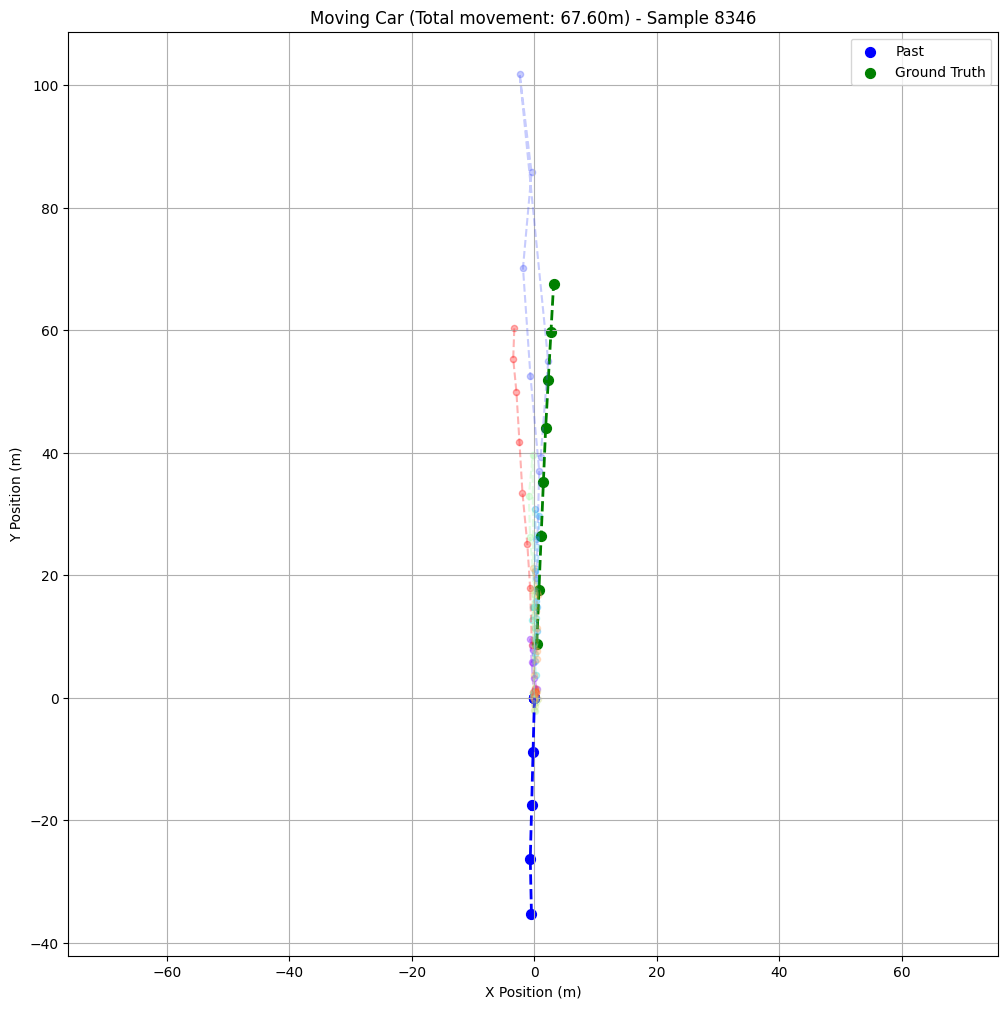


Test Sample 8346:
Total movement: 67.60m
Mean Final Displacement Error: 54.51m
Min Final Displacement Error: 9.61m
Max Final Displacement Error: 68.20m


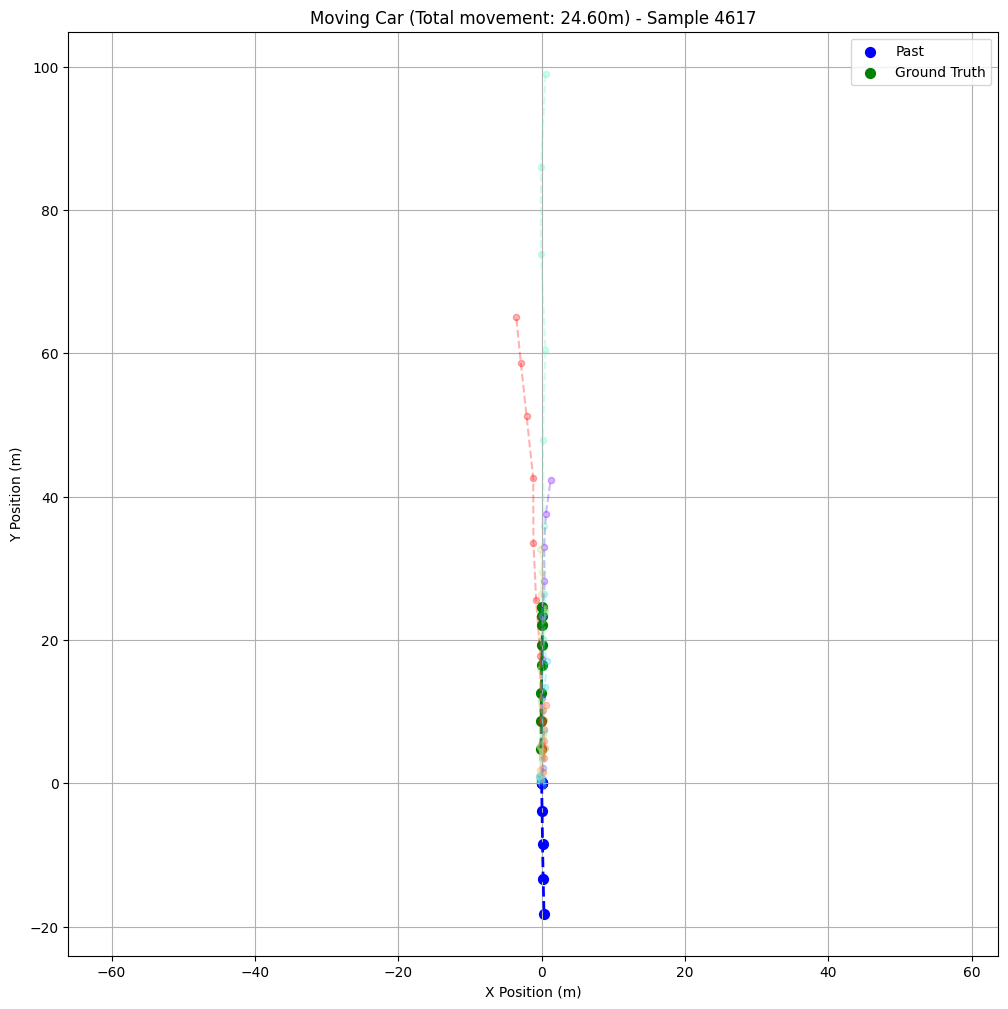


Test Sample 4617:
Total movement: 24.60m
Mean Final Displacement Error: 25.03m
Min Final Displacement Error: 1.89m
Max Final Displacement Error: 74.40m

Overall Testing Statistics:
Average FDE across all samples: 27.30m
Min FDE across all samples: 1.89m
Max FDE across all samples: 74.40m


In [19]:
def test_model():
    # Initialize NuScenes
    dataroot = "/content/drive/MyDrive/v1.0-mini 2"
    nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)
    helper = PredictHelper(nusc)

    # Create test dataset
    dataset = TrajectoryDataset(nusc, helper)

    # Filter for moving car trajectories only
    moving_car_indices = []
    for idx in range(len(dataset)):
        data = dataset[idx]
        if data['category'].startswith('vehicle.car'):
            # Get trajectories and move to CPU for numpy operations
            past_np = data['past'].cpu().numpy()
            future_np = data['future'].cpu().numpy()
            if is_moving_car(past_np, future_np, min_movement=1.0):
                moving_car_indices.append(idx)

    print(f"\nTesting Statistics:")
    print(f"Total trajectories: {len(dataset)}")
    print(f"Moving car trajectories: {len(moving_car_indices)}")

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load model with weights_only=True
    model = load_trained_model('best_diffusion_model.pt', device)

    # Test on multiple moving car trajectories
    num_test_samples = min(5, len(moving_car_indices))
    test_indices = np.random.choice(moving_car_indices, num_test_samples, replace=False)

    overall_fdes = []
    for idx in test_indices:
        data = dataset[idx]
        past = data['past'].unsqueeze(0).to(device)
        future = data['future']

        # Get movement information (move to CPU first)
        past_np = past.cpu().numpy()
        future_np = future.cpu().numpy()
        total_movement = np.linalg.norm(future_np[-1] - past_np[0, 0])

        # Generate multiple predictions
        predictions = generate_multiple_trajectories(
            model,
            past,
            num_samples=10,
            device=device
        )

        # Move predictions to CPU for visualization
        predictions_np = [pred.cpu().numpy() for pred in predictions]

        # Visualize
        visualize_multiple_trajectories(
            past_np[0],
            future_np,
            predictions_np,
            f"Moving Car (Total movement: {total_movement:.2f}m) - Sample {idx}"
        )

        # Calculate metrics
        fde = np.linalg.norm(
            np.stack(predictions_np)[:, -1, :] - future_np[-1:],
            axis=1
        )
        overall_fdes.extend(fde)

        print(f"\nTest Sample {idx}:")
        print(f"Total movement: {total_movement:.2f}m")
        print(f"Mean Final Displacement Error: {fde.mean():.2f}m")
        print(f"Min Final Displacement Error: {fde.min():.2f}m")
        print(f"Max Final Displacement Error: {fde.max():.2f}m")

    # Print overall statistics
    print("\nOverall Testing Statistics:")
    print(f"Average FDE across all samples: {np.mean(overall_fdes):.2f}m")
    print(f"Min FDE across all samples: {np.min(overall_fdes):.2f}m")
    print(f"Max FDE across all samples: {np.max(overall_fdes):.2f}m")

# Also update the model loading function
def load_trained_model(model_path: "/content/best_diffusion_model.pt", device: torch.device) -> DiffusionModel:
    """Load the trained model."""
    model = DiffusionModel(
        history_steps=int(2.0 * 5),  # 2 seconds at 5Hz
        future_steps=int(4.0 * 2)    # 4 seconds at 2Hz
    ).to(device)

    # Load with weights_only=True
    checkpoint = torch.load(model_path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

if __name__ == "__main__":
  test_model()